# <a id='toc1_'></a>[Stress Detection From Wearables](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Stress Detection From Wearables](#toc1_)    
    - [Imports](#toc1_1_1_)    
  - [Data Preprocessing](#toc1_2_)    
    - [Window](#toc1_2_1_)    
  - [Model](#toc1_3_)    
    - [Imports](#toc1_3_1_)    
    - [Build model](#toc1_3_2_)    
    - [Train model](#toc1_3_3_)    
    - [64hz](#toc1_3_4_)    
    - [1 hz](#toc1_3_5_)    
  - [Evaluation](#toc1_4_)    
    - [64hz](#toc1_4_1_)    
  - [Prediction](#toc1_5_)    
  - [MISC](#toc1_6_)    
- [Training with synthetic data](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [363]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from synthesizers.preprocessing.wesad import WESADDataset
from typing import List, Tuple, Dict
from enum import Enum

## <a id='toc1_2_'></a>[Data Preprocessing](#toc0_)

In [80]:
DATA_PATH = 'data/wesad/preprocessed_1hz.csv'
SAMPLING_RATE = 1

df = pd.read_csv(DATA_PATH, index_col=0)
trainX, label_trainX = WESADDataset.create_windows(df, 1)

### <a id='toc1_2_1_'></a>[Window](#toc0_)

1. Creating the windows
2. Create subwindows from the windows
3. Calculate the fft of the subwindows
4. Average the subwindows

![fft](../images/fft.png)

In [81]:
# Subwindow length of the biosignals
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

In [82]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

# if stress occurress in time interval return 1
def check_for_stress(lst):
    return max(set(lst))

In [83]:
def create_windows(df: pd.DataFrame, fs: int) -> tuple[np.ndarray,list]:
    """Creates windows from the dataframe and returns the windows and the labels.
    If the window is assigned to multiple labels, the most common label is chosen for that period.

    Args:
        df (pd.DataFrame): Subject DataFrame
        fs (int): Samples per second

    Returns:
        tuple[np.ndarray,list]: Windows representing the activity of the subject in one minute and the corresponding labels.
    """
    # Create an empty list for the windows and labels
    windows = []
    labels = []

    # Calculate the window length in samples
    window_len = fs * 60

    # Loop over the rows in the DataFrame to create the windows
    for i in range(0, df.shape[0]-window_len, window_len):
        # Get the window data and label
        window = df[i:i+window_len]
        label = int(check_for_stress(df['label'][i:i+window_len].to_list()))

        # Convert the window data to a numpy array
        window = window.to_numpy()

        # Add the window and label to the list
        windows.append(window)
        labels.append(label)

    # Convert the windows and labels to numpy arrays
    windows = np.array(windows)
    labels = np.array(labels)

    # Return the windows and labels as a tuple
    return windows, labels


In [4]:
def create_subwindows(window: np.array, signal_subwindow_len: int, signal_name: str, fs: int) -> np.array:
    """The function creates subwindows from the windows.

    Args:
        df (pd.DataFrame): Windows representing the activity of the subject in one minute.
        signal_subwindow_len (int): Length of the subwindows.
        signal_name (str): Name of the signal.
        fs (int): Samples per second

    Returns:
        list: Subwindows of the signal in the window.
    """

    subwindow_len = fs * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = fs * 60 # fs = 64 and window length in seconds = 60
    window_shift = 1 if fs < 4 else int(fs * 0.25) # fs = 64 and window shift in seconds = 0.25

    subwindows = np.asarray([window[i:i+subwindow_len] for i in range(0, window_len - subwindow_len + 1, window_shift)])
            
    return subwindows

In [5]:
def fft_subwindows(subwindows: list, duration: int, fs: int) -> list:
    """Calculates the fft of the subwindows.

    Args:
        subwindows (list): C
        duration (int): _description_
        f_s (int): _description_

    Returns:
        list: Fft coefficients of the subwindows.
    """
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = fs * duration
        freq = scipy.fft.fftfreq(N, 1/fs)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs), np.asarray(yfs)

In [6]:
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0) -> np.ndarray:

    pad_size = target_length - array.shape[axis]

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

In [7]:
def fft_subwindows(subwindows: list, duration: int, fs: int) -> list:
    """Calculates the fft of the subwindows.

    Args:
        subwindows (list): C
        duration (int): _description_
        f_s (int): _description_

    Returns:
        list: Fft coefficients of the subwindows.
    """
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = fs * duration
        freq = scipy.fft.fftfreq(N, 1/fs)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs), np.asarray(yfs)
    

In [8]:
def average_window(subwindows_fft: list) -> list:
    """Calculates the average of the fft coefficients of the subwindows.

    Args:
        subwindows_fft (list): List of fft coefficients of the subwindows.

    Returns:
        list: Average of the fft coefficients of the subwindow for signals.
    """
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

In [9]:
def create_training_data_per_subject(fs, windows, yfs_per_min_for_signal):
        
    X = []
    for i in range(0,len(windows) - 1):
        yfs_averages = []
        for j, signal in enumerate(signal_subwindow_dict.keys()):
            duration_in_sec = signal_subwindow_dict[signal]
            subwindows = create_subwindows(windows[i,:,j], signal_subwindow_len=duration_in_sec, signal_name=signal, fs=fs)
            _, yfs = fft_subwindows(subwindows, duration_in_sec, fs=fs)
            padded_yfs = pad_along_axis(yfs, target_length=210, axis=1) 
            yfs_averages.append(average_window(padded_yfs)[:210])
                
        X.append(yfs_averages)
    return np.array(X)

def create_preprocessed_subjects_data(subjects_data: dict, fs: int = 64) -> dict:
# Creates averaged windows for all subjects from dataframes

    subjects_preprosessed_data = {}
    for subject_name, subject_df in subjects_data.items():
        subjects_preprosessed_data[subject_name] = {}
        windows, labels = create_windows(subject_df, fs=fs)
        yfs_per_min_for_signal = {}
        X = create_training_data_per_subject(fs, windows, yfs_per_min_for_signal)
        y = np.array((labels[:len(windows)-1]))

        subjects_preprosessed_data[subject_name]['X'] = X
        subjects_preprosessed_data[subject_name]['y'] = y
    
    return subjects_preprosessed_data


In [10]:
def create_training_data_per_subject_gen(fs, windows):
        
    X = []
    for i in range(0,len(windows) - 1):
        yfs_averages = []
        for j, signal in enumerate(signal_subwindow_dict.keys()):
            duration_in_sec = signal_subwindow_dict[signal]
            subwindows = create_subwindows(windows[i,:,j], signal_subwindow_len=duration_in_sec, signal_name=signal, fs=fs)
            # print("Subwindow Shape: ", subwindows.shape)
            _, yfs = fft_subwindows(subwindows, duration_in_sec, fs=fs)
            
            # print("fft_subwindows Shape: ", yfs.shape)
            padded_yfs = pad_along_axis(yfs, target_length=210, axis=1) 
            # orint("padded fft_subwindows Shape: ", padded_yfs.shape)
            yfs_averages.append(average_window(padded_yfs)[:210])
                
        X.append(yfs_averages)
    return np.array(X)

In [397]:
def create_preprocessed_subjects_data_gen(windows: np.array, fs: int = 64) -> Tuple:
# Creates averaged windows for all subjects from dataframes

    print("Windows Shape: ", windows.shape)
    yfs_per_min_for_signal = {}
    X = create_training_data_per_subject_gen(fs, windows)
    
    y = np.array((X[:,0,6][:len(X)]))

    print(f"X Shape:", X.shape)
    print(f"y Shape:", y.shape)

    return X, y

In [12]:
def get_subject_window_data(subjects_preprosessed_data: Dict) -> Tuple[List, List]:
    # Created train and test data for leave one out cross validation
    all_subjects_X = [subject_data['X'] for subject_data in subjects_preprosessed_data.values()]
    all_subjects_y = [subject_data['y'] for subject_data in subjects_preprosessed_data.values()]
    
    return all_subjects_X, all_subjects_y

In [385]:
class DataType(Enum):
    CGAN = 0
    DGAN = 1
    REAL = 2

In [355]:
DATA_PATH = '/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD'
SYNTHETIC_DGAN_DATA_PATH = '/Users/nils/thesis/gretel-synthetics/src/syn_df_30000_1hz'
SYNTHETIC_CGAN_DATA_PATH = 'data/syn/cond_syn_gen.npy'
# SYNTHETIC_DATA_PATH = "/Users/nils/thesis/gretel-synthetics/syn_df"
SAMPLING_RATE = 1
SUBJECT_IDS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [357]:
def save_subject_data(subjects_data, save_path: str):
    # save dictionary as pickle file
    with open(save_path, 'wb') as f:
        pickle.dump(subjects_data, f)

In [364]:
def load_data(data_type: DataType, sampling_rate: int, synthetic_data_path: str) -> Tuple[List, List]:
    """
    Load preprocessed data from disk or create it from scratch.

    Args:
        data_type: The type of data to load (real or synthetic).
        sampling_rate: The sampling rate of the data.
        data_path: The path to the data directory.
        subject_ids: The list of subject IDs to include in the data.
        synthetic_data_path: The path to the synthetic data CSV file.
        load_from_disk: Whether to load data from disk or create it from scratch.

    Returns:
        A tuple of NumPy arrays containing the windowed data and corresponding labels.

    Raises:
        FileNotFoundError: If the data file is not found.
    """

    try:
        # load dictionary from pickle file
        print("*** Try to load data from disk ***\n")
        with open(f'data/wesad/subject_data_{sampling_rate}hz.pickle', 'rb') as f:
            subjects_data = pickle.load(f)

    except FileNotFoundError:
        print("*** File not found ***")
        print("*** Preprocess data ***")
        dataset = WESADDataset(DATA_PATH, SUBJECT_IDS)
        subjects_data = dataset.get_subject_dataframes(sampling_rate=sampling_rate)
        save_subject_data(subjects_data, f"data/wesad/subject_data_{sampling_rate}hz.pickle")

    if data_type == DataType.DGAN:
        print("*** Add synthetic data to DGAN ***")
        syn_df = pd.read_csv(synthetic_data_path, index_col=0)
        subjects_data['SYN'] = syn_df
    
    subjects_preprocessed_data = create_preprocessed_subjects_data(subjects_data, fs=sampling_rate)
    all_subjects_X, all_subjects_y = get_subject_window_data(subjects_preprocessed_data)

    if data_type == DataType.CGAN:
        print("*** Add synthetic data to CGAN ***")
        with open(synthetic_data_path, "rb") as f:
            gen_data = np.load(f) 
        X, y = create_preprocessed_subjects_data_gen(gen_data, fs=1)

        all_subjects_X.append(X)
        all_subjects_y.append(y)
    
    return all_subjects_X, all_subjects_y

In [365]:
all_subjects_X, all_subjects_y = load_data(DataType.CGAN, sampling_rate=1, synthetic_data_path=SYNTHETIC_CGAN_DATA_PATH)

*** Try to load data from disk ***

*** Add synthetic data to CGAN ***
Windows Shape:  (500, 60, 7)
X Shape: (499, 6, 210)
y Shape: (499,)


![OS_Sensors](../images/os_sensors.png)

In [381]:
SIGNALS = ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP']

In [400]:
SMARTWATCH_OS = {
    'E4': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP'],
    'E4_DGAN': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP'],
    'E4_CGAN': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP'],
    #'Tizen': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'BVP'],
    #'WearOS_watchOS': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP'],
    #'Fitbit': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA'],
    #'PiaOS': ['TEMP', 'EDA', 'BVP']
    }

In [383]:
def filter_for_smartwatch_os(smartwatch_os_name: str, all_subjects_X: list) -> list:
    # Adjusts the data for the smartwatch os
    all_subjects_X_adjusted_for_smartwatch_os = []
    for subject_data in all_subjects_X:
        subject_adjusted_for_smartwatch_os = []
        for window in subject_data:
            subject_adjusted_for_smartwatch_os.append(window.loc[SMARTWATCH_OS[smartwatch_os_name]])
        all_subjects_X_adjusted_for_smartwatch_os.append(subject_adjusted_for_smartwatch_os)
    return all_subjects_X_adjusted_for_smartwatch_os


In [384]:
def filter_for_smartwatch_os_new(smartwatch_os_name: str, all_subjects_X: list) -> list:
    # Adjusts the data for the smartwatch os
    all_subjects_X_adjusted_for_smartwatch_os = []
    for subject_data in all_subjects_X:
        subject_adjusted_for_smartwatch_os = []
        for window in subject_data:
            subject_adjusted_for_smartwatch_os.append(window.loc[SMARTWATCH_OS[smartwatch_os_name]])
        all_subjects_X_adjusted_for_smartwatch_os.append(subject_adjusted_for_smartwatch_os)
    return all_subjects_X_adjusted_for_smartwatch_os


In [ ]:
filter_for_smartwatch_os('E4', all_subjects_X)

## <a id='toc1_3_'></a>[Model](#toc0_)

### <a id='toc1_3_1_'></a>[Imports](#toc0_)

In [36]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

### <a id='toc1_3_2_'></a>[Build model](#toc0_)

![model_architecture](../images/model_architecture.png)

In [37]:
def build_model(num_signals: int = 6, num_output_class: int = 2) -> tf.keras.models.Sequential:

    num_output_class = 2
    # Define the model architecture
    model = tf.keras.Sequential()
    # input_shape = 14 Signale (bei uns max. 6) X 210 Inputs (aus Tabelle nach Fourier)
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same')) 
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    # Anzahl der Units = Anzahl der Klassen (2 - non-stress vs stress)
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid')) # sigmoid statt softmax, da nur 2 Klassen


    optimizer = "rmsprop"

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy', 
        metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall()
        ]
    )
    return model

### <a id='toc1_3_3_'></a>[Train model](#toc0_)

In [129]:
subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [388]:
def train(smart_os, signals, all_subjects_X, all_subjects_y, data_type: DataType, num_epochs: int):
    print(f'\n\n\nSmartwatchOS: {smart_os}')
    print(f'DataType: {data_type}')
    print(f'Signals: {" ".join(signals)}')
    print(f'Number of signals: {len(signals)}')

    # changed - no filter for smartwatch
    # all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)
    all_subjects_X_os = all_subjects_X
    if data_type in (DataType.DGAN, DataType.CGAN):
        groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 'SYN'] # ids for subjects in WESAD dataset
    if data_type == DataType.REAL:
        groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
        subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] # ids for subjects in WESAD dataset
    num_signals = len(signals) # Number of signals in the WESAD dataset measured by the empatica e4
    num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
    # num_epochs = 100

    for i in groups_set:
        
        test_index = groups_set[i]
        train_index = [x for x in groups_set if x != test_index]

        print(f'Train on: {train_index}')
        print(f'Test  on: {test_index}')

        X_train = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
        y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
        X_test = all_subjects_X_os[test_index]
        y_test = all_subjects_y[test_index]
        
        weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

        X_train = np.asarray(X_train)
        X_test = np.asarray(X_test)
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)

        y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

        tf.keras.backend.clear_session()

        model = build_model(num_signals, num_output_class)

        if data_type == DataType.REAL:
            model_path = f"models/stress_detector/real/{num_epochs}/wesad_s{subject_ids[test_index]}.h5"  # Path to save the model file
        if data_type == DataType.DGAN:
            model_path = f"models/stress_detector/syn/dgan_30000/{num_epochs}/wesad_s{subject_ids[test_index]}.h5"
        if data_type == DataType.CGAN:
            model_path = f"models/stress_detector/syn/cgan/{num_epochs}/wesad_s{subject_ids[test_index]}.h5"

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                model_path,
                # f"models/{smart_os}/wesad_{smart_os}_binary_s_syn_{num_epochs}.h5",  # Path to save the model file
                # f"models/syn/wesad_{smart_os}_binary_s_syn_{num_epochs}.h5",  # Path to save the model file
                monitor="loss", # The metric name to monitor
                save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
            ),
            tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)  
        ]
        
    
        history = model.fit(
            X_train, 
            y_train,
            epochs=num_epochs, 
            batch_size=50,
            verbose=1,
            class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
            callbacks = callbacks,
            validation_data=(X_test, y_test)
        )
    

In [428]:
all_subjects_X, all_subjects_y = load_data(DataType.CGAN, 1, synthetic_data_path=SYNTHETIC_CGAN_DATA_PATH)

*** Try to load data from disk ***

*** Add synthetic data to CGAN ***
Windows Shape:  (36, 60, 7)
X Shape: (35, 6, 210)
y Shape: (35,)


In [429]:
# for smart_os, signals in SMARTWATCH_OS.items():
train("E4", SIGNALS, all_subjects_X, all_subjects_y, DataType.CGAN, num_epochs = 100)




SmartwatchOS: E4
DataType: DataType.CGAN
Signals: ACC_x ACC_y ACC_z TEMP EDA BVP
Number of signals: 6
Train on: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Test  on: 0
Epoch 1/100


2023-04-25 21:04:35.072929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9707 - accuracy: 0.6384 - precision: 0.6128 - recall: 0.6648

2023-04-25 21:05:18.156606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 47s 3s/step - loss: 0.9707 - accuracy: 0.6384 - precision: 0.6128 - recall: 0.6648 - val_loss: 0.5992 - val_accuracy: 0.7941 - val_precision: 0.7941 - val_recall: 0.7941
Epoch 2/100
11/11 [==============================] - 5s 428ms/step - loss: 0.8218 - accuracy: 0.7401 - precision: 0.7158 - recall: 0.7495 - val_loss: 0.5159 - val_accuracy: 0.8824 - val_precision: 0.9286 - val_recall: 0.7647
Epoch 3/100
11/11 [==============================] - 7s 460ms/step - loss: 0.7487 - accuracy: 0.7458 - precision: 0.7481 - recall: 0.7382 - val_loss: 0.5651 - val_accuracy: 0.8235 - val_precision: 0.8621 - val_recall: 0.7353
Epoch 4/100
11/11 [==============================] - 3s 337ms/step - loss: 0.6733 - accuracy: 0.8079 - precision: 0.8090 - recall: 0.8136 - val_loss: 0.5561 - val_accuracy: 0.8235 - val_precision: 0.8889 - val_recall: 0.7059
Epoch 5/100
11/11 [==============================] - 2s 205ms/step - loss: 0.6123 - accuracy: 0.7947 - precision: 

2023-04-25 21:06:01.090583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9735 - accuracy: 0.6121 - precision: 0.6082 - recall: 0.6139

2023-04-25 21:06:43.224828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 46s 3s/step - loss: 0.9735 - accuracy: 0.6121 - precision: 0.6082 - recall: 0.6139 - val_loss: 0.6314 - val_accuracy: 0.6765 - val_precision: 0.6765 - val_recall: 0.6765
Epoch 2/100
11/11 [==============================] - 10s 990ms/step - loss: 0.8775 - accuracy: 0.7119 - precision: 0.7028 - recall: 0.7081 - val_loss: 0.6015 - val_accuracy: 0.6765 - val_precision: 0.6389 - val_recall: 0.6765
Epoch 3/100
11/11 [==============================] - 3s 258ms/step - loss: 0.7311 - accuracy: 0.7872 - precision: 0.7759 - recall: 0.7891 - val_loss: 0.6266 - val_accuracy: 0.6765 - val_precision: 0.6765 - val_recall: 0.6765
Epoch 4/100
11/11 [==============================] - 3s 276ms/step - loss: 0.6691 - accuracy: 0.7834 - precision: 0.7854 - recall: 0.7928 - val_loss: 0.5624 - val_accuracy: 0.7353 - val_precision: 0.7353 - val_recall: 0.7353
Epoch 5/100
11/11 [==============================] - 3s 277ms/step - loss: 0.5851 - accuracy: 0.8305 - precision:

2023-04-25 21:07:49.618787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9723 - accuracy: 0.5868 - precision: 0.6125 - recall: 0.5906

2023-04-25 21:08:35.575575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 50s 3s/step - loss: 0.9723 - accuracy: 0.5868 - precision: 0.6125 - recall: 0.5906 - val_loss: 0.5850 - val_accuracy: 0.9143 - val_precision: 0.8462 - val_recall: 0.9429
Epoch 2/100
11/11 [==============================] - 10s 827ms/step - loss: 0.9054 - accuracy: 0.6642 - precision: 0.6598 - recall: 0.6623 - val_loss: 0.5038 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 3/100
11/11 [==============================] - 2s 221ms/step - loss: 0.7908 - accuracy: 0.7604 - precision: 0.7439 - recall: 0.7453 - val_loss: 0.4124 - val_accuracy: 0.9714 - val_precision: 0.9714 - val_recall: 0.9714
Epoch 4/100
11/11 [==============================] - 3s 319ms/step - loss: 0.6563 - accuracy: 0.8000 - precision: 0.7929 - recall: 0.8019 - val_loss: 0.3242 - val_accuracy: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 5/100
11/11 [==============================] - 4s 385ms/step - loss: 0.6804 - accuracy: 0.8019 - precision:

2023-04-25 21:09:46.505711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9650 - accuracy: 0.6094 - precision: 0.6029 - recall: 0.6189

2023-04-25 21:10:31.031116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 48s 3s/step - loss: 0.9650 - accuracy: 0.6094 - precision: 0.6029 - recall: 0.6189 - val_loss: 0.6637 - val_accuracy: 0.6857 - val_precision: 0.6500 - val_recall: 0.7429
Epoch 2/100
11/11 [==============================] - 7s 616ms/step - loss: 0.8792 - accuracy: 0.6811 - precision: 0.6780 - recall: 0.6755 - val_loss: 0.5947 - val_accuracy: 0.7714 - val_precision: 0.7714 - val_recall: 0.7714
Epoch 3/100
11/11 [==============================] - 5s 486ms/step - loss: 0.7204 - accuracy: 0.7755 - precision: 0.7744 - recall: 0.7774 - val_loss: 0.3360 - val_accuracy: 0.9429 - val_precision: 0.9706 - val_recall: 0.9429
Epoch 4/100
11/11 [==============================] - 2s 187ms/step - loss: 0.6683 - accuracy: 0.8075 - precision: 0.8095 - recall: 0.8019 - val_loss: 0.2678 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 5/100
11/11 [==============================] - 1s 98ms/step - loss: 0.6231 - accuracy: 0.8226 - precision: 0

2023-04-25 21:11:47.431027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9937 - accuracy: 0.6509 - precision: 0.6201 - recall: 0.6623

2023-04-25 21:12:24.106081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 41s 3s/step - loss: 0.9937 - accuracy: 0.6509 - precision: 0.6201 - recall: 0.6623 - val_loss: 0.6178 - val_accuracy: 0.6571 - val_precision: 0.6970 - val_recall: 0.6571
Epoch 2/100
11/11 [==============================] - 8s 798ms/step - loss: 0.9165 - accuracy: 0.6717 - precision: 0.6692 - recall: 0.6717 - val_loss: 0.4921 - val_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 3/100
11/11 [==============================] - 6s 543ms/step - loss: 0.7669 - accuracy: 0.7509 - precision: 0.7429 - recall: 0.7415 - val_loss: 0.5139 - val_accuracy: 0.7143 - val_precision: 0.7143 - val_recall: 0.7143
Epoch 4/100
11/11 [==============================] - 3s 254ms/step - loss: 0.6981 - accuracy: 0.7906 - precision: 0.7887 - recall: 0.7887 - val_loss: 0.3250 - val_accuracy: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 5/100
11/11 [==============================] - 3s 252ms/step - loss: 0.6494 - accuracy: 0.8245 - precision: 

2023-04-25 21:13:37.249122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.6208 - precision: 0.6326 - recall: 0.5491

2023-04-25 21:14:24.631418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 52s 4s/step - loss: 0.9824 - accuracy: 0.6208 - precision: 0.6326 - recall: 0.5491 - val_loss: 0.6677 - val_accuracy: 0.6286 - val_precision: 0.7000 - val_recall: 0.6000
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 0.9077 - accuracy: 0.6566 - precision: 0.6634 - recall: 0.6434 - val_loss: 0.5863 - val_accuracy: 0.7714 - val_precision: 0.7714 - val_recall: 0.7714
Epoch 3/100
11/11 [==============================] - 8s 547ms/step - loss: 0.7867 - accuracy: 0.7396 - precision: 0.7402 - recall: 0.7472 - val_loss: 0.2953 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 4/100
11/11 [==============================] - 2s 217ms/step - loss: 0.6978 - accuracy: 0.7830 - precision: 0.7939 - recall: 0.7849 - val_loss: 0.4550 - val_accuracy: 0.7714 - val_precision: 0.7879 - val_recall: 0.7429
Epoch 5/100
11/11 [==============================] - 1s 58ms/step - loss: 0.6631 - accuracy: 0.7906 - precision: 0.7

2023-04-25 21:15:51.901211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9850 - accuracy: 0.6057 - precision: 0.6088 - recall: 0.5755

2023-04-25 21:16:43.611532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 56s 4s/step - loss: 0.9850 - accuracy: 0.6057 - precision: 0.6088 - recall: 0.5755 - val_loss: 0.6119 - val_accuracy: 0.9714 - val_precision: 0.8293 - val_recall: 0.9714
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.9185 - accuracy: 0.6774 - precision: 0.6839 - recall: 0.6981 - val_loss: 0.4408 - val_accuracy: 0.9714 - val_precision: 0.9714 - val_recall: 0.9714
Epoch 3/100
11/11 [==============================] - 4s 439ms/step - loss: 0.8015 - accuracy: 0.7264 - precision: 0.7212 - recall: 0.7321 - val_loss: 0.5059 - val_accuracy: 0.9143 - val_precision: 0.8889 - val_recall: 0.9143
Epoch 4/100
11/11 [==============================] - 8s 757ms/step - loss: 0.6491 - accuracy: 0.7830 - precision: 0.7709 - recall: 0.7811 - val_loss: 0.2326 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 5/100
11/11 [==============================] - 6s 461ms/step - loss: 0.6664 - accuracy: 0.8132 - precision: 0.

2023-04-25 21:18:18.895408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.6151 - precision: 0.6059 - recall: 0.5830

2023-04-25 21:19:19.710197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 66s 5s/step - loss: 0.9714 - accuracy: 0.6151 - precision: 0.6059 - recall: 0.5830 - val_loss: 0.7148 - val_accuracy: 0.3429 - val_precision: 0.4103 - val_recall: 0.4571
Epoch 2/100
11/11 [==============================] - 7s 694ms/step - loss: 0.8507 - accuracy: 0.6962 - precision: 0.6951 - recall: 0.6925 - val_loss: 0.4692 - val_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 3/100
11/11 [==============================] - 7s 675ms/step - loss: 0.7441 - accuracy: 0.7623 - precision: 0.7590 - recall: 0.7547 - val_loss: 0.3151 - val_accuracy: 0.9429 - val_precision: 0.8919 - val_recall: 0.9429
Epoch 4/100
11/11 [==============================] - 3s 235ms/step - loss: 0.6581 - accuracy: 0.8189 - precision: 0.8090 - recall: 0.8151 - val_loss: 0.2618 - val_accuracy: 0.9714 - val_precision: 0.9714 - val_recall: 0.9714
Epoch 5/100
11/11 [==============================] - 4s 359ms/step - loss: 0.6455 - accuracy: 0.8226 - precision: 

2023-04-25 21:20:27.193662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.6295 - precision: 0.6176 - recall: 0.5955

2023-04-25 21:21:18.629818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 56s 3s/step - loss: 0.9566 - accuracy: 0.6295 - precision: 0.6176 - recall: 0.5955 - val_loss: 0.6188 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 0.8936 - accuracy: 0.7127 - precision: 0.6990 - recall: 0.6938 - val_loss: 0.6000 - val_accuracy: 0.7500 - val_precision: 0.7174 - val_recall: 0.9167
Epoch 3/100
11/11 [==============================] - 4s 394ms/step - loss: 0.7605 - accuracy: 0.7467 - precision: 0.7352 - recall: 0.7505 - val_loss: 0.4107 - val_accuracy: 0.9722 - val_precision: 0.9722 - val_recall: 0.9722
Epoch 4/100
11/11 [==============================] - 6s 571ms/step - loss: 0.6756 - accuracy: 0.7902 - precision: 0.7889 - recall: 0.7769 - val_loss: 0.3049 - val_accuracy: 0.9722 - val_precision: 0.9722 - val_recall: 0.9722
Epoch 5/100
11/11 [==============================] - 1s 72ms/step - loss: 0.6484 - accuracy: 0.8091 - precision: 0.8

2023-04-25 21:22:45.416741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9574 - accuracy: 0.6163 - precision: 0.6119 - recall: 0.5633

2023-04-25 21:23:34.697334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 54s 4s/step - loss: 0.9574 - accuracy: 0.6163 - precision: 0.6119 - recall: 0.5633 - val_loss: 0.6367 - val_accuracy: 0.6111 - val_precision: 0.5814 - val_recall: 0.6944
Epoch 2/100
11/11 [==============================] - 9s 902ms/step - loss: 0.8081 - accuracy: 0.7278 - precision: 0.7169 - recall: 0.7372 - val_loss: 0.5231 - val_accuracy: 0.7222 - val_precision: 0.7222 - val_recall: 0.7222
Epoch 3/100
11/11 [==============================] - 7s 415ms/step - loss: 0.7009 - accuracy: 0.7826 - precision: 0.7876 - recall: 0.7921 - val_loss: 0.5057 - val_accuracy: 0.8056 - val_precision: 0.7692 - val_recall: 0.8333
Epoch 4/100
11/11 [==============================] - 4s 336ms/step - loss: 0.6702 - accuracy: 0.7921 - precision: 0.7936 - recall: 0.7921 - val_loss: 0.4757 - val_accuracy: 0.7222 - val_precision: 0.7297 - val_recall: 0.7500
Epoch 5/100
11/11 [==============================] - 2s 175ms/step - loss: 0.6443 - accuracy: 0.8147 - precision: 

2023-04-25 21:24:39.766652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.5879 - precision: 0.5833 - recall: 0.6087

2023-04-25 21:25:30.064157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 55s 4s/step - loss: 0.9942 - accuracy: 0.5879 - precision: 0.5833 - recall: 0.6087 - val_loss: 0.5863 - val_accuracy: 0.8889 - val_precision: 0.8889 - val_recall: 0.8889
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.9013 - accuracy: 0.7202 - precision: 0.7077 - recall: 0.6957 - val_loss: 0.4263 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 0.9722
Epoch 3/100
11/11 [==============================] - 4s 372ms/step - loss: 0.7601 - accuracy: 0.7788 - precision: 0.7872 - recall: 0.7694 - val_loss: 0.4301 - val_accuracy: 0.8333 - val_precision: 0.8286 - val_recall: 0.8056
Epoch 4/100
11/11 [==============================] - 3s 284ms/step - loss: 0.6984 - accuracy: 0.7769 - precision: 0.7876 - recall: 0.7921 - val_loss: 0.3726 - val_accuracy: 0.8333 - val_precision: 0.8421 - val_recall: 0.8889
Epoch 5/100
11/11 [==============================] - 2s 231ms/step - loss: 0.6686 - accuracy: 0.7958 - precision: 0.

2023-04-25 21:26:55.941137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9736 - accuracy: 0.6786 - precision: 0.6536 - recall: 0.6597

2023-04-25 21:27:51.140876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 60s 4s/step - loss: 0.9736 - accuracy: 0.6786 - precision: 0.6536 - recall: 0.6597 - val_loss: 0.7796 - val_accuracy: 0.0556 - val_precision: 0.0556 - val_recall: 0.0556
Epoch 2/100
11/11 [==============================] - 11s 740ms/step - loss: 0.8597 - accuracy: 0.7202 - precision: 0.7211 - recall: 0.7183 - val_loss: 0.8666 - val_accuracy: 0.2778 - val_precision: 0.2778 - val_recall: 0.2778
Epoch 3/100
11/11 [==============================] - 5s 460ms/step - loss: 0.6715 - accuracy: 0.8110 - precision: 0.8161 - recall: 0.8223 - val_loss: 0.8880 - val_accuracy: 0.4167 - val_precision: 0.4167 - val_recall: 0.4167
Epoch 4/100
11/11 [==============================] - 4s 350ms/step - loss: 0.6099 - accuracy: 0.8318 - precision: 0.8308 - recall: 0.8261 - val_loss: 0.8834 - val_accuracy: 0.4722 - val_precision: 0.4412 - val_recall: 0.4167
Epoch 5/100
11/11 [==============================] - 3s 290ms/step - loss: 0.5886 - accuracy: 0.8412 - precision:

2023-04-25 21:29:06.471832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9821 - accuracy: 0.6125 - precision: 0.6011 - recall: 0.6068

2023-04-25 21:30:01.051816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 60s 4s/step - loss: 0.9821 - accuracy: 0.6125 - precision: 0.6011 - recall: 0.6068 - val_loss: 0.5894 - val_accuracy: 0.6944 - val_precision: 0.7143 - val_recall: 0.6944
Epoch 2/100
11/11 [==============================] - 11s 997ms/step - loss: 0.8709 - accuracy: 0.7051 - precision: 0.7085 - recall: 0.6938 - val_loss: 0.5296 - val_accuracy: 0.9722 - val_precision: 0.9211 - val_recall: 0.9722
Epoch 3/100
11/11 [==============================] - 4s 349ms/step - loss: 0.7370 - accuracy: 0.7372 - precision: 0.7404 - recall: 0.7278 - val_loss: 0.3323 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 4/100
11/11 [==============================] - 4s 405ms/step - loss: 0.7134 - accuracy: 0.7921 - precision: 0.7891 - recall: 0.7921 - val_loss: 0.2674 - val_accuracy: 0.9722 - val_precision: 0.9722 - val_recall: 0.9722
Epoch 5/100
11/11 [==============================] - 8s 460ms/step - loss: 0.6639 - accuracy: 0.8053 - precision:

2023-04-25 21:31:18.067483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9666 - accuracy: 0.6427 - precision: 0.6289 - recall: 0.6408

2023-04-25 21:32:02.515697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 49s 3s/step - loss: 0.9666 - accuracy: 0.6427 - precision: 0.6289 - recall: 0.6408 - val_loss: 0.7065 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.9210 - accuracy: 0.7372 - precision: 0.7337 - recall: 0.7448 - val_loss: 0.7101 - val_accuracy: 0.4444 - val_precision: 0.4571 - val_recall: 0.4444
Epoch 3/100
11/11 [==============================] - 4s 362ms/step - loss: 0.7803 - accuracy: 0.7807 - precision: 0.7714 - recall: 0.7656 - val_loss: 0.7615 - val_accuracy: 0.4167 - val_precision: 0.4167 - val_recall: 0.4167
Epoch 4/100
11/11 [==============================] - 3s 292ms/step - loss: 0.6913 - accuracy: 0.7713 - precision: 0.7694 - recall: 0.7694 - val_loss: 0.5653 - val_accuracy: 0.6944 - val_precision: 0.6750 - val_recall: 0.7500
Epoch 5/100
11/11 [==============================] - 4s 441ms/step - loss: 0.6403 - accuracy: 0.8223 - precision: 0.

2023-04-25 21:33:37.131992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9973 - accuracy: 0.6163 - precision: 0.6160 - recall: 0.5520

2023-04-25 21:34:26.491474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 54s 3s/step - loss: 0.9973 - accuracy: 0.6163 - precision: 0.6160 - recall: 0.5520 - val_loss: 0.6384 - val_accuracy: 0.6944 - val_precision: 0.6757 - val_recall: 0.6944
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.8892 - accuracy: 0.7127 - precision: 0.6971 - recall: 0.6919 - val_loss: 0.5521 - val_accuracy: 0.6944 - val_precision: 0.6944 - val_recall: 0.6944
Epoch 3/100
11/11 [==============================] - 3s 332ms/step - loss: 0.7986 - accuracy: 0.7505 - precision: 0.7457 - recall: 0.7429 - val_loss: 0.6089 - val_accuracy: 0.6111 - val_precision: 0.6216 - val_recall: 0.6389
Epoch 4/100
11/11 [==============================] - 6s 517ms/step - loss: 0.6284 - accuracy: 0.8204 - precision: 0.8209 - recall: 0.8318 - val_loss: 0.6123 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 5/100
11/11 [==============================] - 3s 278ms/step - loss: 0.5549 - accuracy: 0.8204 - precision: 0.

2023-04-25 21:35:43.042954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9429 - accuracy: 0.6208 - precision: 0.6257 - recall: 0.6151

2023-04-25 21:36:26.323265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 48s 3s/step - loss: 0.9429 - accuracy: 0.6208 - precision: 0.6257 - recall: 0.6151 - val_loss: 0.8062 - val_accuracy: 0.4286 - val_precision: 0.3902 - val_recall: 0.4571
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.8238 - accuracy: 0.7057 - precision: 0.6990 - recall: 0.6925 - val_loss: 0.6412 - val_accuracy: 0.6286 - val_precision: 0.6286 - val_recall: 0.6286
Epoch 3/100
11/11 [==============================] - 8s 802ms/step - loss: 0.6790 - accuracy: 0.7906 - precision: 0.7917 - recall: 0.7887 - val_loss: 0.8060 - val_accuracy: 0.6286 - val_precision: 0.6286 - val_recall: 0.6286
Epoch 4/100
11/11 [==============================] - 7s 720ms/step - loss: 0.5709 - accuracy: 0.8283 - precision: 0.8299 - recall: 0.8283 - val_loss: 1.2030 - val_accuracy: 0.5714 - val_precision: 0.5556 - val_recall: 0.5714
Epoch 5/100
11/11 [==============================] - 2s 180ms/step - loss: 0.5440 - accuracy: 0.8377 - precision: 0.

## <a id='toc1_4_'></a>[Evaluation](#toc0_)

Evaluating every models on the corresponding test dataset not seen during training.

In [430]:
def evaluate(os_scores_acc, os_scores_f1, smart_os, signals, all_subjects_X, all_subjects_y, data_type: DataType, num_epochs: int):

    # all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)
    subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
    
    all_subjects_X_os =  all_subjects_X 
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for i, subject_id in enumerate(subject_ids):
        X_test = all_subjects_X_os[i]
        y_test = all_subjects_y[i]
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
        
        if data_type == DataType.REAL:
            model_path = f"models/stress_detector/real/{num_epochs}/wesad_s{subject_id}.h5"  # Path to save the model file
        if data_type == DataType.DGAN:
            model_path = f"models/stress_detector/syn/dgan_30000/{num_epochs}/wesad_s{subject_id}.h5"
        if data_type == DataType.CGAN:
            model_path = f"models/stress_detector/syn/cgan/{num_epochs}/wesad_s{subject_id}.h5"

        model = tf.keras.models.load_model(model_path)
        accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
        precision = model.evaluate(X_test, y_test, verbose=0, )[2]
        recall = model.evaluate(X_test, y_test, verbose=0, )[3]
        f1 = 2 * precision * recall / (precision + recall)
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

    print(f'Smartwatch OS: {smart_os}')
    print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
    print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
    print("************************************************************************")
    for i in range(len(all_accuracies)):
        print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

    print("************************************************************************")
    print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

    os_scores_acc[smart_os] = all_accuracies
    os_scores_f1[smart_os] = all_f1s

    return os_scores_acc, os_scores_f1

In [431]:
num_epochs = 100
# Evaluating every models on the corresponding test dataset not seen during training.
os_scores_acc = {}
os_scores_f1 = {}

for smart_os, signals in SMARTWATCH_OS.items():
    
    if  smart_os == "E4_CGAN":
        print(smart_os)
        evaluate(os_scores_acc, os_scores_f1, smart_os, signals, all_subjects_X, all_subjects_y, DataType.CGAN, num_epochs=num_epochs)
    if  smart_os == "E4_DGAN":
        print(smart_os)
        evaluate(os_scores_acc, os_scores_f1, smart_os, signals, all_subjects_X, all_subjects_y, DataType.DGAN, num_epochs=num_epochs)
    if smart_os == "E4":
        print("E4")
        evaluate(os_scores_acc, os_scores_f1, smart_os, signals, all_subjects_X, all_subjects_y, DataType.REAL, num_epochs=num_epochs)

E4


2023-04-25 21:40:04.600036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:40:16.749786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:40:26.252977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:40:37.419181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:40:49.903360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:41:02.152385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:41:14.123757: I tensorflow/core/grappler/optimizers/cust

Smartwatch OS: E4
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.97059	0.97059		0.97059		0.97059
S3		 0.82353	0.81818		0.79412		0.80597
S4		 0.97143	0.97143		0.97143		0.97143
S5		 1.00000	1.00000		1.00000		1.00000
S6		 0.94286	0.94286		0.94286		0.94286
S7		 0.94286	0.94286		0.94286		0.94286
S8		 0.94286	0.97059		0.94286		0.95652
S9		 1.00000	1.00000		1.00000		1.00000
S10		 0.97222	0.97143		0.94444		0.95775
S11		 0.80556	0.80000		0.77778		0.78873
S13		 0.97222	0.97222		0.97222		0.97222
S14		 0.27778	0.27778		0.27778		0.27778
S15		 0.97222	0.97222		0.97222		0.97222
S16		 1.00000	1.00000		1.00000		1.00000
S17		 0.66667	0.66667		0.66667		0.66667
************************************************************************
Average		 0.88405	0.88512		0.87839		0.88171



E4_DGAN


2023-04-25 21:42:59.262457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:43:10.219932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:43:19.538938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:43:30.110236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:43:41.188673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:43:54.449773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:44:06.003341: I tensorflow/core/grappler/optimizers/cust

Smartwatch OS: E4_DGAN
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.97059	0.97059		0.97059		0.97059
S3		 0.79412	0.81818		0.79412		0.80597
S4		 0.97143	0.97143		0.97143		0.97143
S5		 1.00000	1.00000		1.00000		1.00000
S6		 0.97143	0.97143		0.97143		0.97143
S7		 0.94286	0.94286		0.94286		0.94286
S8		 1.00000	1.00000		0.94286		0.97059
S9		 1.00000	1.00000		1.00000		1.00000
S10		 0.97222	0.97222		0.97222		0.97222
S11		 0.83333	0.81081		0.83333		0.82192
S13		 1.00000	1.00000		1.00000		1.00000
S14		 0.66667	0.66667		0.66667		0.66667
S15		 0.97222	0.97222		0.97222		0.97222
S16		 0.97222	0.97222		0.97222		0.97222
S17		 0.63889	0.64865		0.66667		0.65753
************************************************************************
Average		 0.91373	0.91449		0.91177		0.91304



E4_CGAN


2023-04-25 21:46:00.195444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:46:13.159648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:46:25.054651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:46:35.761664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:46:47.975016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:46:58.548035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 21:47:11.503751: I tensorflow/core/grappler/optimizers/cust

Smartwatch OS: E4_CGAN
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.88235	0.88235		0.88235		0.88235
S3		 0.85294	0.85294		0.85294		0.85294
S4		 1.00000	1.00000		1.00000		1.00000
S5		 1.00000	1.00000		0.97143		0.98551
S6		 0.94286	0.94286		0.94286		0.94286
S7		 0.94286	0.94286		0.94286		0.94286
S8		 1.00000	1.00000		1.00000		1.00000
S9		 0.97143	0.97143		0.97143		0.97143
S10		 0.97222	0.97059		0.91667		0.94286
S11		 0.83333	0.83333		0.83333		0.83333
S13		 1.00000	1.00000		1.00000		1.00000
S14		 0.05556	0.05556		0.05556		0.05556
S15		 0.97222	0.97222		0.97222		0.97222
S16		 0.94444	0.94444		0.94444		0.94444
S17		 0.75000	0.73684		0.77778		0.75676
************************************************************************
Average		 0.87468	0.87369		0.87092		0.87221





In [435]:
df_os_scores_acc = pd.DataFrame(os_scores_acc)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_acc = df_os_scores_acc.rename(replacements)
df_os_scores_acc.to_csv('os_scores_acc.csv')

In [436]:
df_os_scores_f1 = pd.DataFrame(os_scores_f1)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_f1 = df_os_scores_f1.rename(replacements)
df_os_scores_f1.to_csv('os_scores_f1.csv')

<AxesSubplot: title={'center': 'Accuracy of different os models on each subject'}>

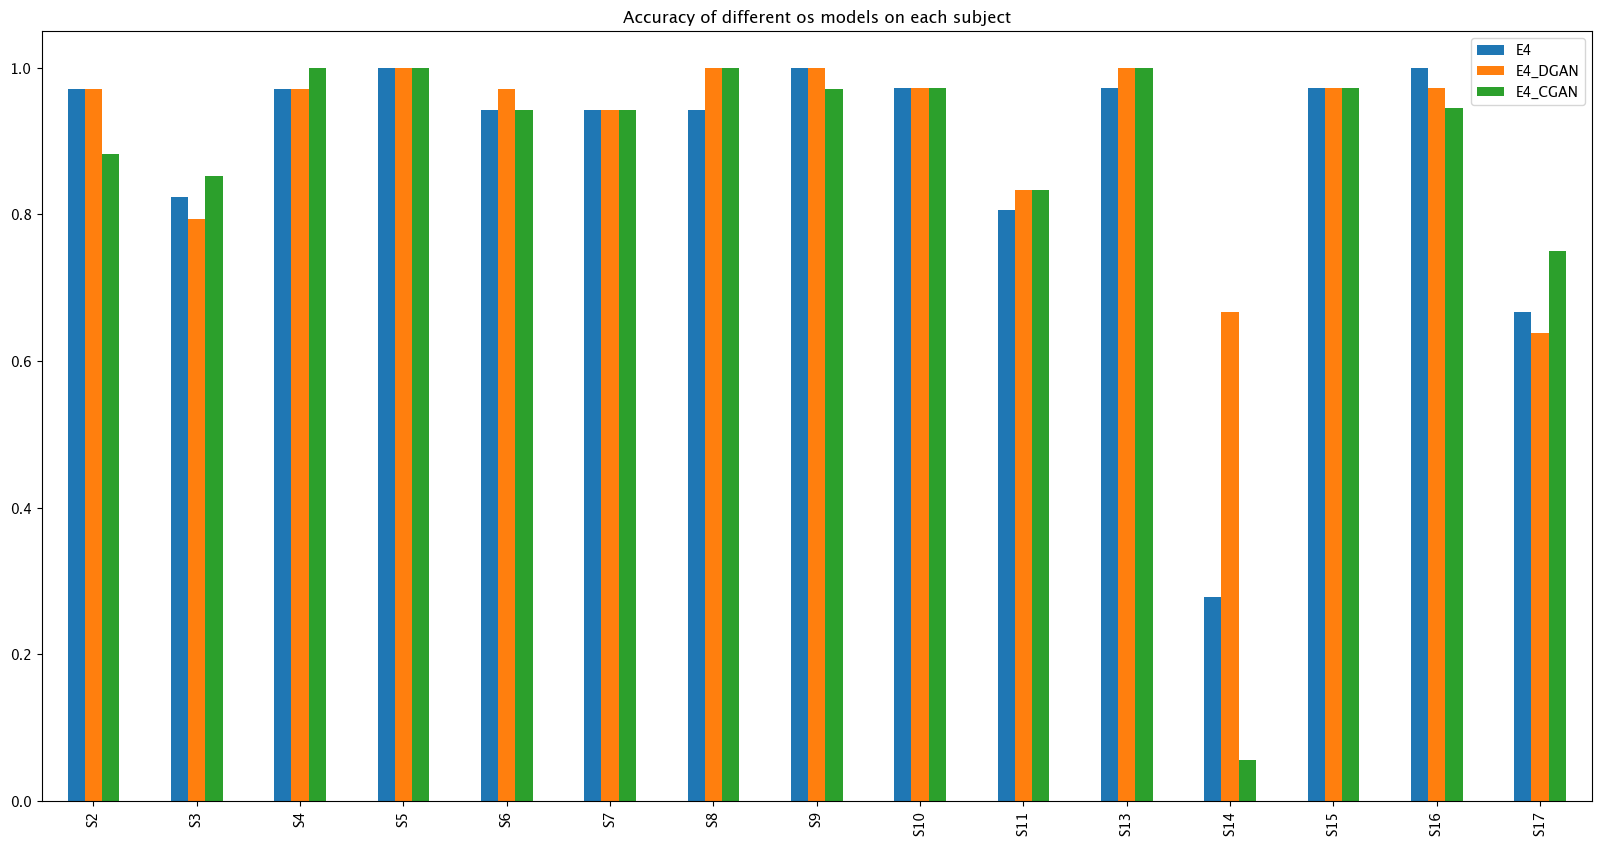

In [437]:
df_os_scores_acc.plot.bar(figsize=(20,10), title='Accuracy of different os models on each subject')

<AxesSubplot: title={'center': 'F1-Score of different os models on each subject'}>

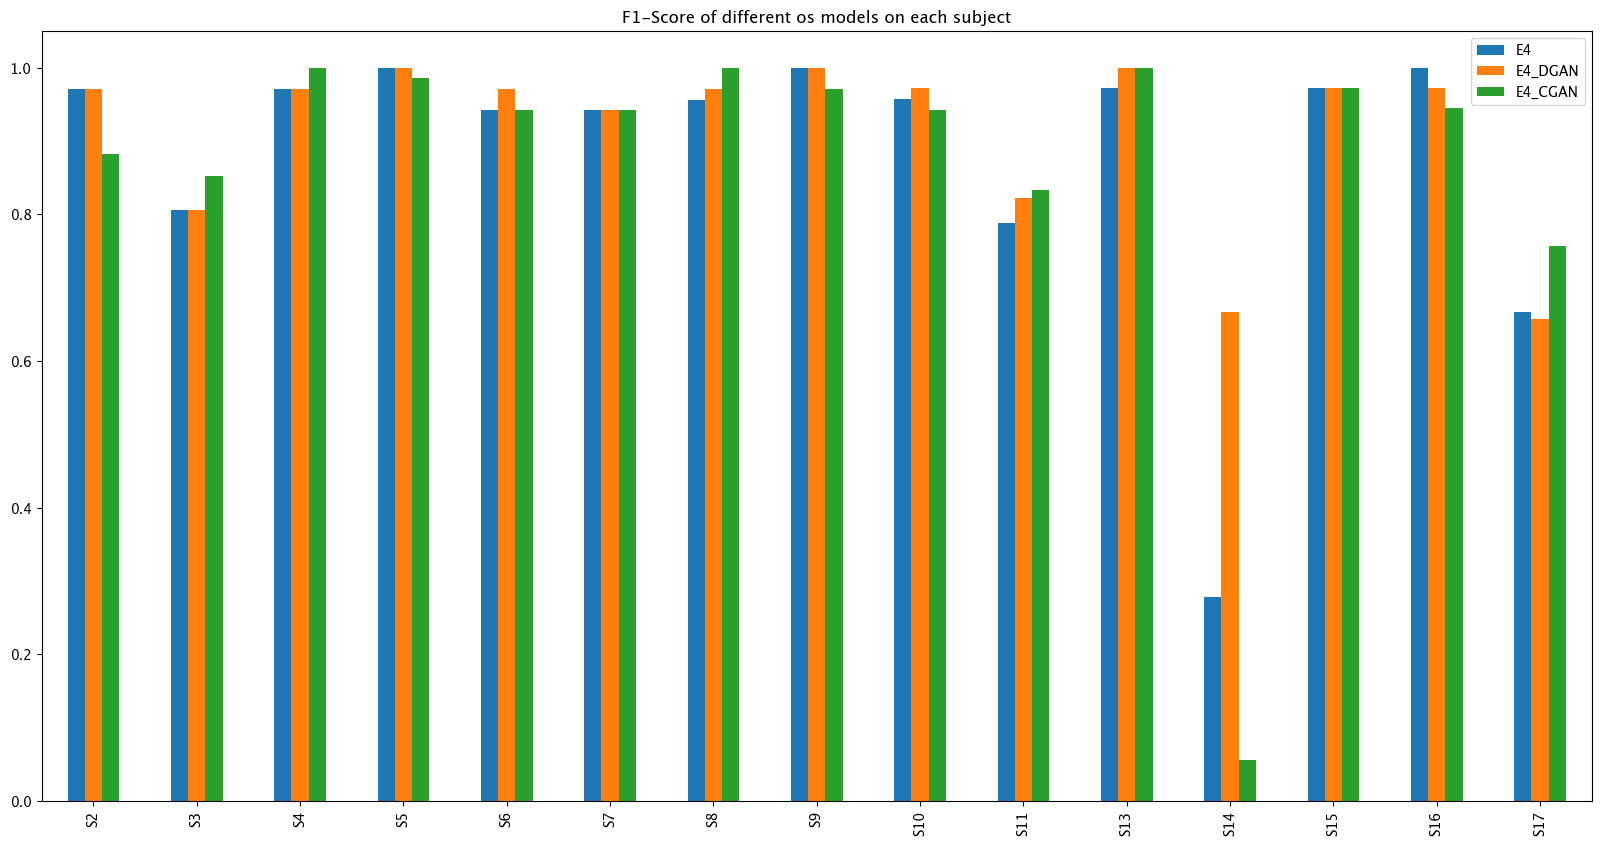

In [438]:
df_os_scores_f1.plot.bar(figsize=(20,10), title='F1-Score of different os models on each subject')

           E4   E4_DGAN   E4_CGAN
S2   0.970588  0.970588  0.882353
S3   0.823529  0.794118  0.852941
S4   0.971429  0.971429  1.000000
S5   1.000000  1.000000  1.000000
S6   0.942857  0.971429  0.942857
S7   0.942857  0.942857  0.942857
S8   0.942857  1.000000  1.000000
S9   1.000000  1.000000  0.971429
S10  0.972222  0.972222  0.972222
S11  0.805556  0.833333  0.833333
S13  0.972222  1.000000  1.000000
S14  0.277778  0.666667  0.055556
S15  0.972222  0.972222  0.972222
S16  1.000000  0.972222  0.944444
S17  0.666667  0.638889  0.750000

E4         0.884052
E4_DGAN    0.913732
E4_CGAN    0.874681
dtype: float64



Text(0.5, 1.0, 'Average accuracy of different models on each OS')

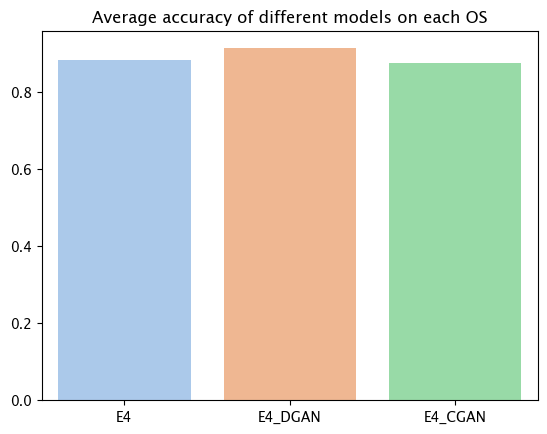

In [439]:
# bar plot of the accuracy of the different loso models
print(f'{df_os_scores_acc}\n')
print(f'{df_os_scores_acc.mean()}\n')
sns.barplot(x=df_os_scores_acc.keys(), y=df_os_scores_acc.mean(), palette='pastel').set_title(label='Average accuracy of different models on each OS')

           E4   E4_DGAN   E4_CGAN
S2   0.970588  0.970588  0.882353
S3   0.805970  0.805970  0.852941
S4   0.971429  0.971429  1.000000
S5   1.000000  1.000000  0.985507
S6   0.942857  0.971429  0.942857
S7   0.942857  0.942857  0.942857
S8   0.956522  0.970588  1.000000
S9   1.000000  1.000000  0.971429
S10  0.957746  0.972222  0.942857
S11  0.788732  0.821918  0.833333
S13  0.972222  1.000000  1.000000
S14  0.277778  0.666667  0.055556
S15  0.972222  0.972222  0.972222
S16  1.000000  0.972222  0.944444
S17  0.666667  0.657534  0.756757

E4         0.881706
E4_DGAN    0.913043
E4_CGAN    0.872208
dtype: float64



Text(0.5, 1.0, 'F1 score of different models on each OS')

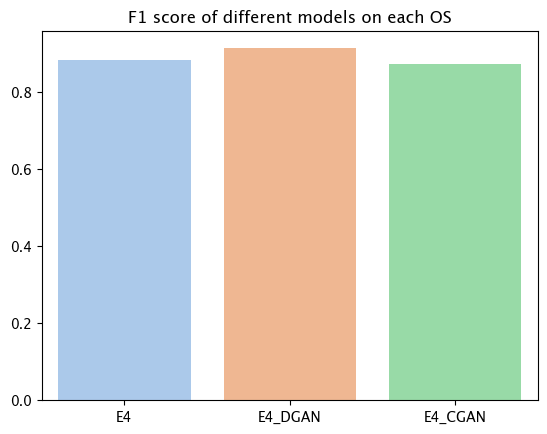

In [440]:
# bar plot of the accuracy of the different loso models
print(f'{df_os_scores_f1}\n')
print(f'{df_os_scores_f1.mean()}\n')
sns.barplot(x=df_os_scores_f1.keys(), y=df_os_scores_f1.mean(), palette='pastel').set_title(label='F1 score of different models on each OS')

## <a id='toc1_5_'></a>[Prediction](#toc0_)

In [ ]:
model_path = "./models/E4/wesad_E4_binary_s10_100.h5"
model = tf.keras.models.load_model(model_path)
predictions = model.predict(X_test) # make predictions on the test set using the trained model
pred_class = np.argmax(predictions, axis=-1) # get the class with the highest probability

In [ ]:
true_classified = 0
for i in range(len(pred_class)):
    print("Prediction: ", predictions[i])
    print("Prediction: ", pred_class[i])
    ground_truth = max(enumerate(y_test[i]),key=lambda x: x[1])[0]
    print("Ground Truth: ", ground_truth)
    print()
    if ground_truth == pred_class[i]:
        true_classified += 1
print("Accuracy: ", true_classified/len(pred_class))
    

## <a id='toc1_6_'></a>[MISC](#toc0_)

In [301]:
X_test = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
y_test = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
X_train = X
y_train = y 
# X_test = all_subjects_X_os[test_index]
# y_test = all_subjects_y[test_index]

weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

tf.keras.backend.clear_session()

model = build_model(num_signals, num_output_class)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"models/syn/wesad_syn_binary_s_{num_epochs}_2000_epoch_data.h5",  # Path to save the model file
    monitor="loss", # The metric name to monitor
    save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",     # Quantity to be monitored.
    min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
    patience=100,        # Number of epochs with no improvement after which training will be stopped.
)

history = model.fit(
X_train, 
y_train,
epochs=num_epochs, 
batch_size=50,
verbose=1,
class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
callbacks = [checkpoint, early_stopping]
)   

Epoch 1/100


2023-03-20 23:05:22.839499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 4s 233ms/step - loss: 0.6605 - accuracy: 0.6090 - precision: 0.6025 - recall: 0.5965
Epoch 2/100
8/8 [==============================] - 1s 117ms/step - loss: 0.4759 - accuracy: 0.7794 - precision: 0.7761 - recall: 0.7644
Epoch 3/100
8/8 [==============================] - 0s 65ms/step - loss: 0.3205 - accuracy: 0.8722 - precision: 0.8737 - recall: 0.8672
Epoch 4/100
8/8 [==============================] - 0s 50ms/step - loss: 0.2513 - accuracy: 0.8847 - precision: 0.8850 - recall: 0.8872
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 0.1525 - accuracy: 0.9348 - precision: 0.9325 - recall: 0.9348
Epoch 6/100
8/8 [==============================] - 0s 33ms/step - loss: 0.1141 - accuracy: 0.9574 - precision: 0.9572 - recall: 0.9524
Epoch 7/100
8/8 [==============================] - 0s 46ms/step - loss: 0.0809 - accuracy: 0.9724 - precision: 0.9747 - recall: 0.9674
Epoch 8/100
8/8 [==============================] - 0s 37ms/step -

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

def build_model(hp, num_signals: int = 6, num_output_class: int = 2) -> tf.keras.models.Sequential:
    num_output_class = 2

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    # Add conv2D layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Choice(f'filters_{i}', values=[32, 64, 128]),
            kernel_size=(1,3),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        ))
        # Add normalization layers
        normalization_layer = hp.Choice(f'normalization_{i}', values=['none', 'batch', 'layer'])
        if normalization_layer == 'batch':
            model.add(BatchNormalization())
        elif normalization_layer == 'layer':
            model.add(LayerNormalization())

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

    model.add(tf.keras.layers.Flatten())

    # Add dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=4)):
        units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        activation = hp.Choice(f'activation_dense_{i}', values=['relu', 'tanh', 'sigmoid'])
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dense(units=units, activation=activation, kernel_initializer='glorot_uniform'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Output layer
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid'))

    # Compile model
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model


In [292]:
# all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)
model_path = f'models/syn/wesad_syn_binary_s_100_2000_epoch_data.h5'

model = tf.keras.models.load_model(model_path)
all_subjects_X_os =  all_subjects_X 
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for i, subject_id in enumerate(subject_ids):
    X_test = all_subjects_X_os[i]
    y_test = all_subjects_y[i]
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
    

    accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
    precision = model.evaluate(X_test, y_test, verbose=0, )[2]
    recall = model.evaluate(X_test, y_test, verbose=0, )[3]
    f1 = 2 * precision * recall / (precision + recall)
    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

print(f'SYN OS: {smart_os}')
print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
print("************************************************************************")
for i in range(len(all_accuracies)):
    print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

print("************************************************************************")
print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

os_scores_acc[smart_os] = all_accuracies
os_scores_f1[smart_os] = all_f1s


2023-03-20 22:35:08.411781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


SYN OS: E4
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.85294	0.85294		0.85294		0.85294
S3		 0.64706	0.64706		0.64706		0.64706
S4		 0.97143	0.97143		0.97143		0.97143
S5		 1.00000	1.00000		1.00000		1.00000
S6		 0.94286	0.94286		0.94286		0.94286
S7		 0.91429	0.91429		0.91429		0.91429
S8		 0.80000	0.80000		0.80000		0.80000
S9		 0.97143	0.97143		0.97143		0.97143
S10		 0.97222	0.97222		0.97222		0.97222
S11		 0.63889	0.63889		0.63889		0.63889
S13		 0.97222	0.97222		0.97222		0.97222
S14		 0.72222	0.72222		0.72222		0.72222
S15		 0.88889	0.88889		0.88889		0.88889
S16		 0.97222	0.97222		0.97222		0.97222
S17		 0.52778	0.54286		0.52778		0.53521
************************************************************************
Average		 0.85296	0.85397		0.85296		0.85346





In [294]:
df_os_scores_acc = pd.DataFrame(os_scores_acc)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_acc = df_os_scores_acc.rename(replacements)
df_os_scores_acc.to_csv('os_scores_acc.csv')

<AxesSubplot: title={'center': 'Accuracy of different os models on each subject'}>

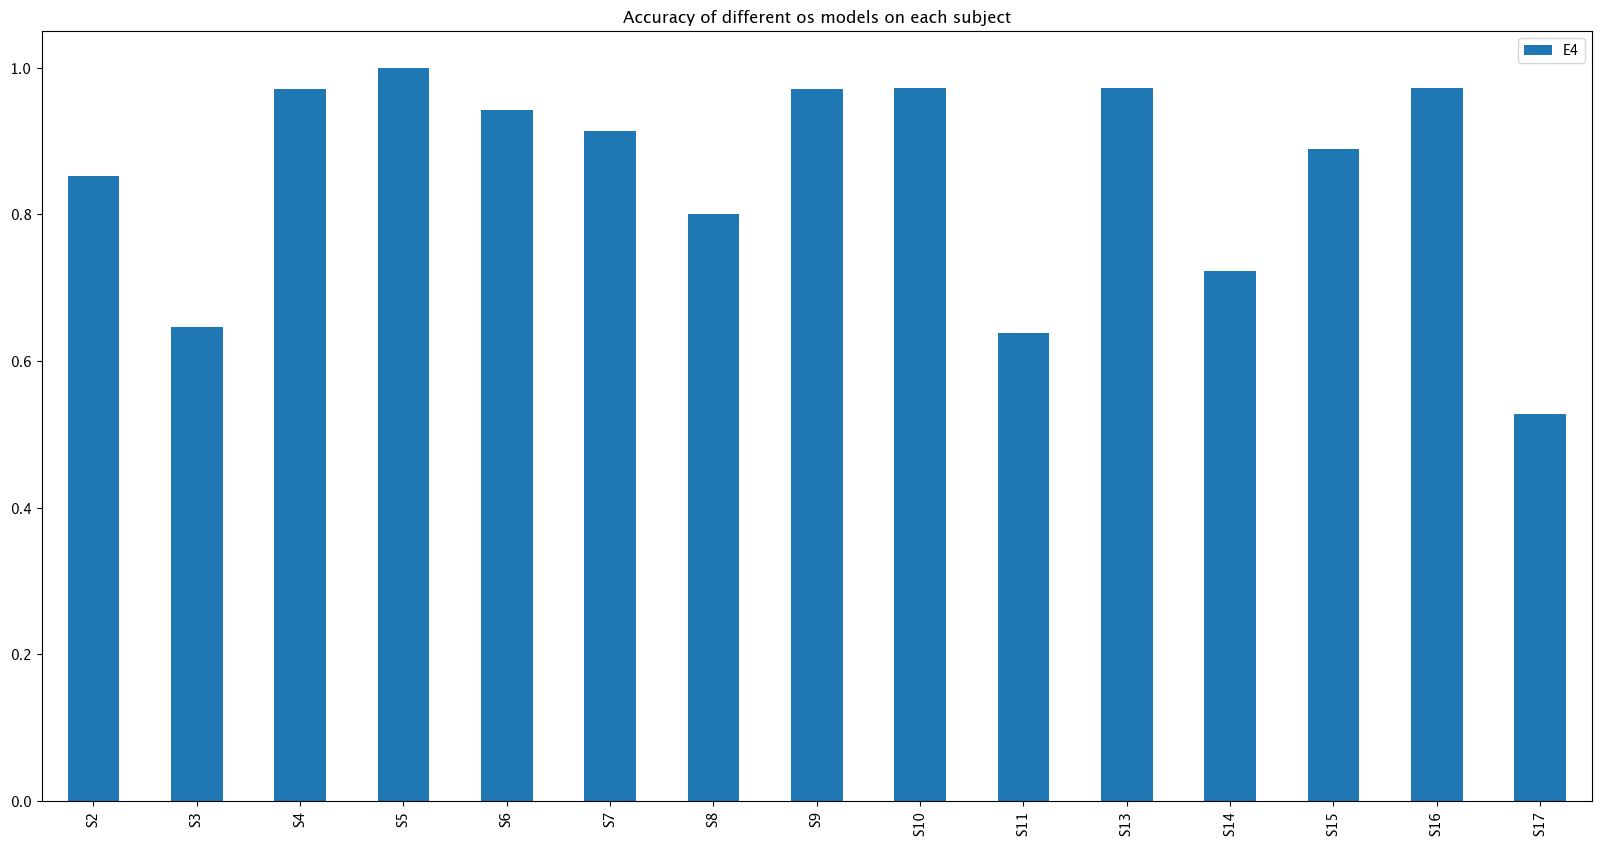

In [295]:
df_os_scores_acc.plot.bar(figsize=(20,10), title='Accuracy of different os models on each subject')

2023-03-20 23:07:39.616560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


SYN OS: E4
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.82353	0.82353		0.82353		0.82353
S3		 0.67647	0.67647		0.67647		0.67647
S4		 0.97143	0.97143		0.97143		0.97143
S5		 1.00000	1.00000		1.00000		1.00000
S6		 0.94286	0.91667		0.94286		0.92958
S7		 0.97143	0.97143		0.97143		0.97143
S8		 0.80000	0.80556		0.82857		0.81690
S9		 0.97143	0.97143		0.97143		0.97143
S10		 0.97222	0.97222		0.97222		0.97222
S11		 0.66667	0.66667		0.66667		0.66667
S13		 0.97222	0.97222		0.97222		0.97222
S14		 0.69444	0.67568		0.69444		0.68493
S15		 0.88889	0.86486		0.88889		0.87671
S16		 0.97222	0.97222		0.97222		0.97222
S17		 0.58333	0.58333		0.58333		0.58333
************************************************************************
Average		 0.86048	0.85625		0.86238		0.85927





<AxesSubplot: title={'center': 'Accuracy of different os models on each subject'}>

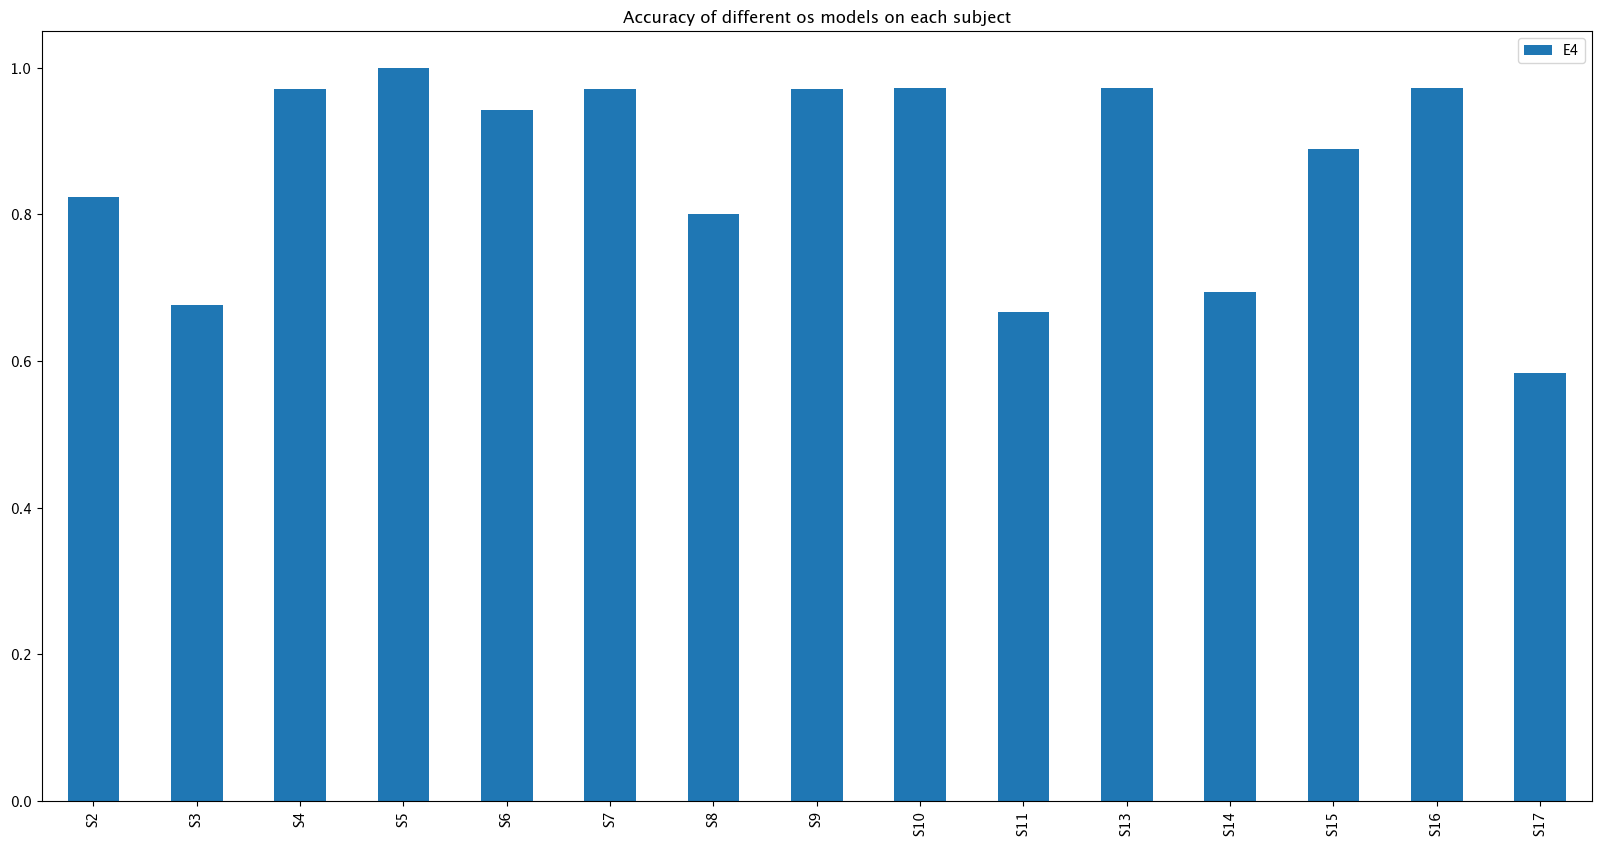

In [302]:
# all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)
model_path = f'models/syn/wesad_syn_binary_s_100_2000_epoch_data.h5'

model = tf.keras.models.load_model(model_path)
all_subjects_X_os =  all_subjects_X 
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for i, subject_id in enumerate(subject_ids):
    X_test = all_subjects_X_os[i]
    y_test = all_subjects_y[i]
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
    

    accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
    precision = model.evaluate(X_test, y_test, verbose=0, )[2]
    recall = model.evaluate(X_test, y_test, verbose=0, )[3]
    f1 = 2 * precision * recall / (precision + recall)
    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

print(f'SYN OS: {smart_os}')
print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
print("************************************************************************")
for i in range(len(all_accuracies)):
    print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

print("************************************************************************")
print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

os_scores_acc[smart_os] = all_accuracies
os_scores_f1[smart_os] = all_f1s

df_os_scores_acc = pd.DataFrame(os_scores_acc)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_acc = df_os_scores_acc.rename(replacements)
df_os_scores_acc.to_csv('os_scores_acc.csv')

df_os_scores_acc.plot.bar(figsize=(20,10), title='Accuracy of different os models on each subject')

In [30]:
with open("/Users/nils/thesis/Data_Generation/syn_gen_data_2806.npy", "rb") as f:
    gen_data = np.load(f) 
X, y = create_preprocessed_subjects_data_gen(gen_data, fs=1)

Windows Shape:  (500, 60, 7)
X Shape: (499, 6, 210)
y Shape: (499,)


In [336]:
num_epochs = 100

X_test = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
y_test = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
X_train = X
y_train = y 
# X_test = all_subjects_X_os[test_index]
# y_test = all_subjects_y[test_index]

weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

tf.keras.backend.clear_session()

model = build_model(num_signals, num_output_class)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"models/syn/wesad_syn_binary_s_{num_epochs}_2806_epoch_data.h5",  # Path to save the model file
    monitor="loss", # The metric name to monitor
    save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # Quantity to be monitored.
    patience=5,
)

history = model.fit(
X_train, 
y_train,
epochs=num_epochs, 
batch_size=32,
verbose=1,
class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
callbacks = [checkpoint, early_stopping],
validation_data=(X_test, y_test)
)   

Epoch 1/100


2023-03-21 13:51:50.325100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.6653 - precision: 0.6612 - recall: 0.6493

2023-03-21 13:51:54.823606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 6s 261ms/step - loss: 0.6123 - accuracy: 0.6653 - precision: 0.6612 - recall: 0.6493 - val_loss: 9.7906 - val_accuracy: 0.7621 - val_precision: 0.7620 - val_recall: 0.7681
Epoch 2/100
16/16 [==============================] - 1s 66ms/step - loss: 0.4205 - accuracy: 0.7976 - precision: 0.8037 - recall: 0.7876 - val_loss: 10.9562 - val_accuracy: 0.8387 - val_precision: 0.8404 - val_recall: 0.8387
Epoch 3/100
16/16 [==============================] - 1s 45ms/step - loss: 0.3403 - accuracy: 0.8477 - precision: 0.8497 - recall: 0.8497 - val_loss: 6.7723 - val_accuracy: 0.8589 - val_precision: 0.8438 - val_recall: 0.8710
Epoch 4/100
16/16 [==============================] - 1s 53ms/step - loss: 0.3232 - accuracy: 0.8477 - precision: 0.8531 - recall: 0.8497 - val_loss: 5.4760 - val_accuracy: 0.8387 - val_precision: 0.8386 - val_recall: 0.8488
Epoch 5/100
16/16 [==============================] - 1s 40ms/step - loss: 0.3104 - accuracy: 0.8697 - precision: 0

2023-03-21 10:21:27.826194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


SYN OS: E4
Evaluation of CNN model trained on 1000 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.79412	0.79412		0.79412		0.79412
S3		 0.73529	0.73529		0.73529		0.73529
S4		 0.88571	0.88571		0.88571		0.88571
S5		 0.94286	0.94286		0.94286		0.94286
S6		 0.91429	0.91176		0.88571		0.89855
S7		 0.88571	0.88571		0.88571		0.88571
S8		 0.82857	0.82857		0.82857		0.82857
S9		 0.77143	0.77143		0.77143		0.77143
S10		 0.94444	0.94444		0.94444		0.94444
S11		 0.58333	0.58333		0.58333		0.58333
S13		 0.94444	0.94444		0.94444		0.94444
S14		 0.66667	0.66667		0.66667		0.66667
S15		 0.91667	0.91667		0.91667		0.91667
S16		 0.88889	0.88889		0.88889		0.88889
S17		 0.63889	0.63889		0.63889		0.63889
************************************************************************
Average		 0.82275	0.82259		0.82085		0.82171





<AxesSubplot: title={'center': 'Accuracy of different os models on each subject'}>

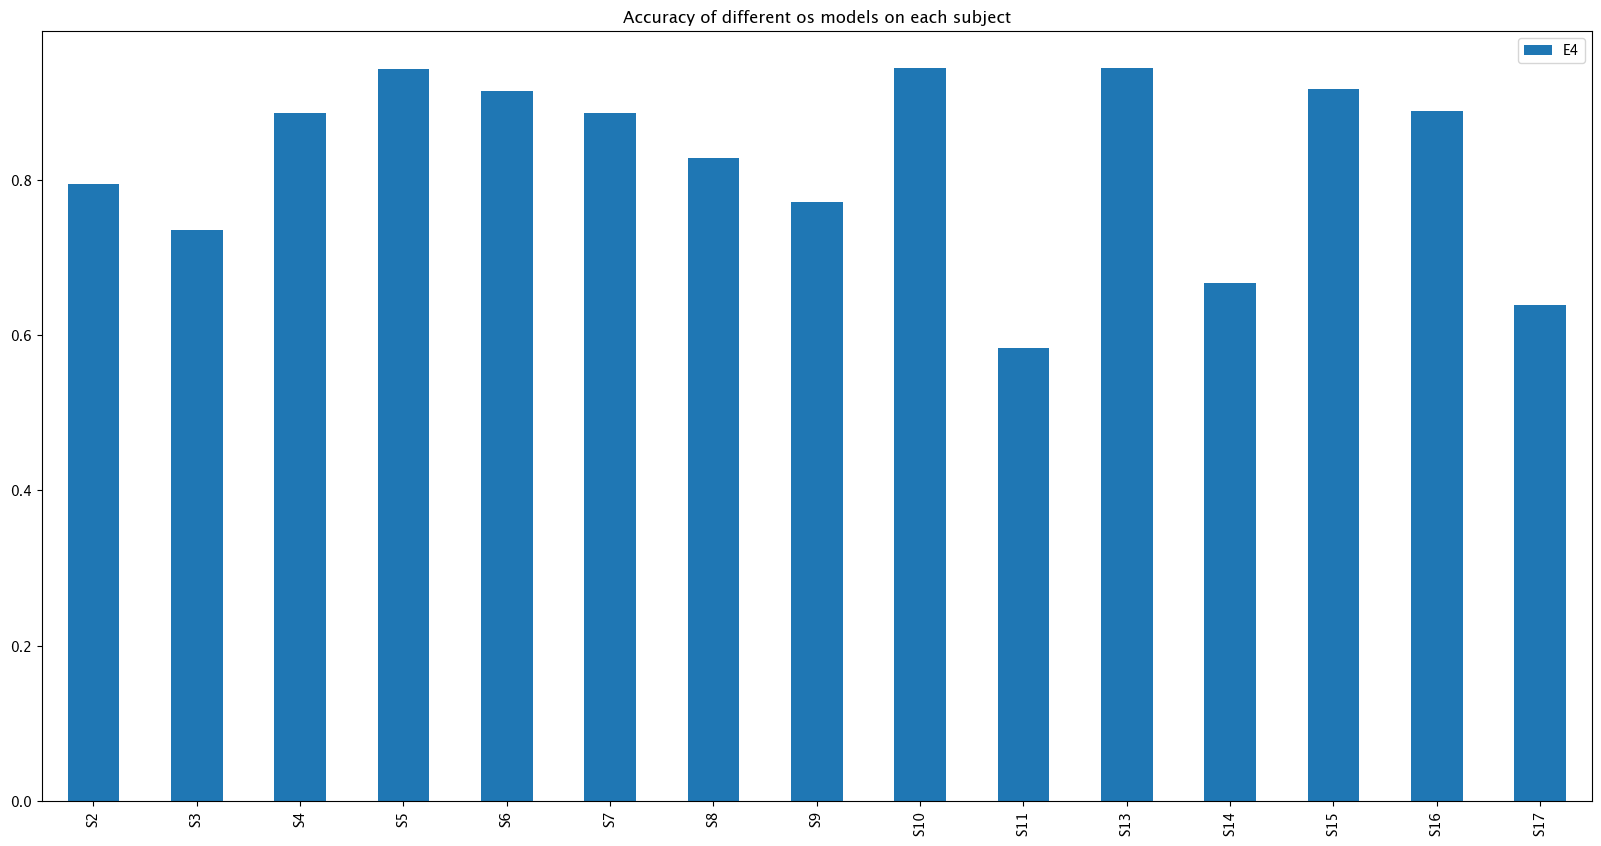

In [332]:
# all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)
# num_epochs = 10
model_path = f'models/syn/wesad_syn_binary_s_{num_epochs}_2806_epoch_data.h5'

model = tf.keras.models.load_model(model_path)
all_subjects_X_os =  all_subjects_X 
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for i, subject_id in enumerate(subject_ids):
    X_test = all_subjects_X_os[i]
    y_test = all_subjects_y[i]
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
    

    accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
    precision = model.evaluate(X_test, y_test, verbose=0, )[2]
    recall = model.evaluate(X_test, y_test, verbose=0, )[3]
    f1 = 2 * precision * recall / (precision + recall)
    all_accuracies.append(accuracy)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

print(f'SYN OS: {smart_os}')
print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
print("************************************************************************")
for i in range(len(all_accuracies)):
    print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

print("************************************************************************")
print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

os_scores_acc[smart_os] = all_accuracies
os_scores_f1[smart_os] = all_f1s

df_os_scores_acc = pd.DataFrame(os_scores_acc)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_acc = df_os_scores_acc.rename(replacements)
df_os_scores_acc.to_csv('os_scores_acc.csv')

df_os_scores_acc.plot.bar(figsize=(20,10), title='Accuracy of different os models on each subject')

In [113]:
# Evaluating every models on the corresponding test dataset not seen during training.
os_scores_acc = {}
os_scores_f1 = {}

for smart_os, signals in SMARTWATCH_OS.items():

    # all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)

    all_subjects_X_os =  all_subjects_X 
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for i, subject_id in enumerate(subject_ids):
        X_test = all_subjects_X_os[i]
        y_test = all_subjects_y[i]
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
        
        
        model_path = f'models/stress_detector/syn/dgan_30000/{num_epochs}/wesad_30000_s{subject_id}.h5'

        model = tf.keras.models.load_model(model_path)
        accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
        precision = model.evaluate(X_test, y_test, verbose=0, )[2]
        recall = model.evaluate(X_test, y_test, verbose=0, )[3]
        f1 = 2 * precision * recall / (precision + recall)
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

    print(f'Smartwatch OS: {smart_os}')
    print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
    print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
    print("************************************************************************")
    for i in range(len(all_accuracies)):
        print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

    print("************************************************************************")
    print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

    os_scores_acc[smart_os] = all_accuracies
    os_scores_f1[smart_os] = all_f1s


2023-04-25 11:54:34.599101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 11:54:38.488606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 11:54:42.010100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 11:54:46.005435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 11:54:49.827045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 11:54:53.504377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 11:54:57.655700: I tensorflow/core/grappler/optimizers/cust

Smartwatch OS: E4
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.97059	0.97059		0.97059		0.97059
S3		 0.79412	0.81818		0.79412		0.80597
S4		 0.97143	0.97143		0.97143		0.97143
S5		 1.00000	1.00000		1.00000		1.00000
S6		 0.97143	0.97143		0.97143		0.97143
S7		 0.94286	0.94286		0.94286		0.94286
S8		 1.00000	1.00000		0.94286		0.97059
S9		 1.00000	1.00000		1.00000		1.00000
S10		 0.97222	0.97222		0.97222		0.97222
S11		 0.83333	0.81081		0.83333		0.82192
S13		 1.00000	1.00000		1.00000		1.00000
S14		 0.66667	0.66667		0.66667		0.66667
S15		 0.97222	0.97222		0.97222		0.97222
S16		 0.97222	0.97222		0.97222		0.97222
S17		 0.63889	0.64865		0.66667		0.65753
************************************************************************
Average		 0.91373	0.91449		0.91177		0.91304





# <a id='toc2_'></a>[Training with synthetic data](#toc0_)

### CGAN

In [398]:
all_subjects_X, all_subjects_y = load_data(DataType.REAL, 1, synthetic_data_path=SYNTHETIC_DATA_PATH)

DATA_PATH = "data/syn/cond_syn_gen.npy"
with open(DATA_PATH, "rb") as f:
    gen_data = np.load(f) 
X, y = create_preprocessed_subjects_data_gen(gen_data, fs=1)

all_subjects_X.append(X)
all_subjects_y.append(y)

*** Try to load data from disk ***

Windows Shape:  (36, 60, 7)
X Shape: (35, 6, 210)
y Shape: (35,)


In [399]:
# for smart_os, signals in SMARTWATCH_OS.items():
train("E4", SIGNALS, all_subjects_X, all_subjects_y, DataType.CGAN, num_epochs = 10)




SmartwatchOS: E4
DataType: DataType.CGAN
Signals: ACC_x ACC_y ACC_z TEMP EDA BVP
Number of signals: 6
Train on: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Test  on: 0
Epoch 1/10


2023-04-25 20:15:08.418958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.6384 - precision: 0.6208 - recall: 0.6535

2023-04-25 20:15:46.208328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 42s 3s/step - loss: 0.9590 - accuracy: 0.6384 - precision: 0.6208 - recall: 0.6535 - val_loss: 0.4995 - val_accuracy: 0.8235 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 2/10
11/11 [==============================] - 13s 961ms/step - loss: 0.8090 - accuracy: 0.7345 - precision: 0.7255 - recall: 0.7119 - val_loss: 0.4587 - val_accuracy: 0.8235 - val_precision: 0.9259 - val_recall: 0.7353
Epoch 3/10
11/11 [==============================] - 2s 239ms/step - loss: 0.7366 - accuracy: 0.7684 - precision: 0.7723 - recall: 0.7665 - val_loss: 0.3546 - val_accuracy: 0.8235 - val_precision: 0.8485 - val_recall: 0.8235
Epoch 4/10
11/11 [==============================] - 2s 189ms/step - loss: 0.6955 - accuracy: 0.8004 - precision: 0.8083 - recall: 0.8023 - val_loss: 0.3358 - val_accuracy: 0.8235 - val_precision: 0.8485 - val_recall: 0.8235
Epoch 5/10
11/11 [==============================] - 1s 133ms/step - loss: 0.6488 - accuracy: 0.8173 - precision: 0.8

2023-04-25 20:16:22.338505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9659 - accuracy: 0.6610 - precision: 0.6323 - recall: 0.6930

2023-04-25 20:17:04.179704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 46s 3s/step - loss: 0.9659 - accuracy: 0.6610 - precision: 0.6323 - recall: 0.6930 - val_loss: 0.6214 - val_accuracy: 0.6765 - val_precision: 0.6667 - val_recall: 0.6471
Epoch 2/10
11/11 [==============================] - 4s 416ms/step - loss: 0.8188 - accuracy: 0.7269 - precision: 0.7295 - recall: 0.7213 - val_loss: 0.7162 - val_accuracy: 0.6176 - val_precision: 0.5714 - val_recall: 0.4706
Epoch 3/10
11/11 [==============================] - 3s 309ms/step - loss: 0.7172 - accuracy: 0.7778 - precision: 0.7761 - recall: 0.7571 - val_loss: 0.6334 - val_accuracy: 0.6765 - val_precision: 0.6765 - val_recall: 0.6765
Epoch 4/10
11/11 [==============================] - 4s 382ms/step - loss: 0.6064 - accuracy: 0.8230 - precision: 0.8245 - recall: 0.8230 - val_loss: 0.5207 - val_accuracy: 0.7353 - val_precision: 0.7353 - val_recall: 0.7353
Epoch 5/10
11/11 [==============================] - 2s 189ms/step - loss: 0.5409 - accuracy: 0.8324 - precision: 0.83

2023-04-25 20:17:30.079110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.6151 - precision: 0.6192 - recall: 0.6321

2023-04-25 20:18:11.812923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 46s 3s/step - loss: 0.9631 - accuracy: 0.6151 - precision: 0.6192 - recall: 0.6321 - val_loss: 0.5849 - val_accuracy: 0.9714 - val_precision: 0.9722 - val_recall: 1.0000
Epoch 2/10
11/11 [==============================] - 8s 666ms/step - loss: 0.8294 - accuracy: 0.7226 - precision: 0.7218 - recall: 0.7000 - val_loss: 0.5426 - val_accuracy: 0.9714 - val_precision: 0.9189 - val_recall: 0.9714
Epoch 3/10
11/11 [==============================] - 4s 361ms/step - loss: 0.7418 - accuracy: 0.7566 - precision: 0.7628 - recall: 0.7585 - val_loss: 0.3302 - val_accuracy: 0.9714 - val_precision: 0.9706 - val_recall: 0.9429
Epoch 4/10
11/11 [==============================] - 3s 286ms/step - loss: 0.6926 - accuracy: 0.7887 - precision: 0.7790 - recall: 0.7849 - val_loss: 0.3095 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 5/10
11/11 [==============================] - 2s 200ms/step - loss: 0.6471 - accuracy: 0.8358 - precision: 0.83

2023-04-25 20:18:37.677858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.5698 - precision: 0.5684 - recall: 0.5491

2023-04-25 20:19:09.937431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 36s 2s/step - loss: 1.0097 - accuracy: 0.5698 - precision: 0.5684 - recall: 0.5491 - val_loss: 0.6664 - val_accuracy: 0.7429 - val_precision: 0.7429 - val_recall: 0.7429
Epoch 2/10
11/11 [==============================] - 13s 1s/step - loss: 0.8854 - accuracy: 0.6755 - precision: 0.6810 - recall: 0.6566 - val_loss: 0.6135 - val_accuracy: 0.7143 - val_precision: 0.7188 - val_recall: 0.6571
Epoch 3/10
11/11 [==============================] - 3s 311ms/step - loss: 0.7568 - accuracy: 0.7717 - precision: 0.7635 - recall: 0.7491 - val_loss: 0.3844 - val_accuracy: 0.9429 - val_precision: 0.9706 - val_recall: 0.9429
Epoch 4/10
11/11 [==============================] - 2s 184ms/step - loss: 0.6537 - accuracy: 0.8000 - precision: 0.8023 - recall: 0.7962 - val_loss: 0.2815 - val_accuracy: 0.9143 - val_precision: 0.9697 - val_recall: 0.9143
Epoch 5/10
11/11 [==============================] - 3s 291ms/step - loss: 0.6638 - accuracy: 0.8226 - precision: 0.8252

2023-04-25 20:19:41.782098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6358 - precision: 0.6216 - recall: 0.6075

2023-04-25 20:20:25.156547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 47s 3s/step - loss: 0.9607 - accuracy: 0.6358 - precision: 0.6216 - recall: 0.6075 - val_loss: 0.5896 - val_accuracy: 0.8286 - val_precision: 0.8108 - val_recall: 0.8571
Epoch 2/10
11/11 [==============================] - 5s 415ms/step - loss: 0.8601 - accuracy: 0.6981 - precision: 0.6897 - recall: 0.6792 - val_loss: 0.5742 - val_accuracy: 0.7143 - val_precision: 0.7000 - val_recall: 0.6000
Epoch 3/10
11/11 [==============================] - 4s 385ms/step - loss: 0.7004 - accuracy: 0.7736 - precision: 0.7650 - recall: 0.7679 - val_loss: 0.2692 - val_accuracy: 0.9429 - val_precision: 0.9167 - val_recall: 0.9429
Epoch 4/10
11/11 [==============================] - 2s 181ms/step - loss: 0.6749 - accuracy: 0.7906 - precision: 0.7841 - recall: 0.7811 - val_loss: 0.2526 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 5/10
11/11 [==============================] - 4s 446ms/step - loss: 0.6321 - accuracy: 0.8321 - precision: 0.83

2023-04-25 20:20:54.771459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.6113 - precision: 0.6217 - recall: 0.6264

2023-04-25 20:21:35.965546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 45s 3s/step - loss: 0.9617 - accuracy: 0.6113 - precision: 0.6217 - recall: 0.6264 - val_loss: 0.7163 - val_accuracy: 0.2857 - val_precision: 0.2941 - val_recall: 0.2857
Epoch 2/10
11/11 [==============================] - 10s 1s/step - loss: 0.8628 - accuracy: 0.7264 - precision: 0.7250 - recall: 0.7264 - val_loss: 0.7392 - val_accuracy: 0.2857 - val_precision: 0.2941 - val_recall: 0.2857
Epoch 3/10
11/11 [==============================] - 3s 325ms/step - loss: 0.7395 - accuracy: 0.7528 - precision: 0.7528 - recall: 0.7528 - val_loss: 0.2332 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 4/10
11/11 [==============================] - 2s 237ms/step - loss: 0.7181 - accuracy: 0.7623 - precision: 0.7686 - recall: 0.7585 - val_loss: 0.3196 - val_accuracy: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 5/10
11/11 [==============================] - 1s 123ms/step - loss: 0.5972 - accuracy: 0.8434 - precision: 0.8447

2023-04-25 20:22:04.575516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.6132 - precision: 0.6106 - recall: 0.5887

2023-04-25 20:22:43.290276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 43s 3s/step - loss: 0.9847 - accuracy: 0.6132 - precision: 0.6106 - recall: 0.5887 - val_loss: 0.5682 - val_accuracy: 0.9429 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 2/10
11/11 [==============================] - 10s 807ms/step - loss: 0.8541 - accuracy: 0.7321 - precision: 0.7151 - recall: 0.7340 - val_loss: 0.4130 - val_accuracy: 0.9429 - val_precision: 0.9706 - val_recall: 0.9429
Epoch 3/10
11/11 [==============================] - 2s 243ms/step - loss: 0.7261 - accuracy: 0.7660 - precision: 0.7685 - recall: 0.7642 - val_loss: 0.3105 - val_accuracy: 0.9714 - val_precision: 0.9714 - val_recall: 0.9714
Epoch 4/10
11/11 [==============================] - 3s 268ms/step - loss: 0.6607 - accuracy: 0.8151 - precision: 0.8127 - recall: 0.8189 - val_loss: 0.2541 - val_accuracy: 0.9143 - val_precision: 0.9143 - val_recall: 0.9143
Epoch 5/10
11/11 [==============================] - 2s 156ms/step - loss: 0.6393 - accuracy: 0.8226 - precision: 0.8

2023-04-25 20:23:16.481076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9806 - accuracy: 0.6283 - precision: 0.6308 - recall: 0.5868

2023-04-25 20:23:53.799100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 41s 2s/step - loss: 0.9806 - accuracy: 0.6283 - precision: 0.6308 - recall: 0.5868 - val_loss: 0.6966 - val_accuracy: 0.4286 - val_precision: 0.4783 - val_recall: 0.6286
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.8670 - accuracy: 0.6774 - precision: 0.6742 - recall: 0.6755 - val_loss: 0.4715 - val_accuracy: 0.7429 - val_precision: 0.7317 - val_recall: 0.8571
Epoch 3/10
11/11 [==============================] - 4s 359ms/step - loss: 0.7186 - accuracy: 0.7962 - precision: 0.7825 - recall: 0.7943 - val_loss: 0.3292 - val_accuracy: 0.8857 - val_precision: 0.8947 - val_recall: 0.9714
Epoch 4/10
11/11 [==============================] - 3s 331ms/step - loss: 0.6695 - accuracy: 0.8094 - precision: 0.8075 - recall: 0.8075 - val_loss: 0.2782 - val_accuracy: 0.9714 - val_precision: 0.9714 - val_recall: 0.9714
Epoch 5/10
11/11 [==============================] - 3s 319ms/step - loss: 0.7119 - accuracy: 0.7849 - precision: 0.7836

2023-04-25 20:24:31.103727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.5671 - precision: 0.5787 - recall: 0.5142

2023-04-25 20:25:12.847701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 46s 3s/step - loss: 0.9945 - accuracy: 0.5671 - precision: 0.5787 - recall: 0.5142 - val_loss: 0.6588 - val_accuracy: 0.8056 - val_precision: 0.7857 - val_recall: 0.9167
Epoch 2/10
11/11 [==============================] - 9s 774ms/step - loss: 0.8805 - accuracy: 0.7089 - precision: 0.6968 - recall: 0.6994 - val_loss: 0.6374 - val_accuracy: 0.5556 - val_precision: 0.5526 - val_recall: 0.5833
Epoch 3/10
11/11 [==============================] - 5s 472ms/step - loss: 0.8070 - accuracy: 0.6881 - precision: 0.6751 - recall: 0.7032 - val_loss: 0.4886 - val_accuracy: 0.9722 - val_precision: 0.9459 - val_recall: 0.9722
Epoch 4/10
11/11 [==============================] - 2s 222ms/step - loss: 0.6819 - accuracy: 0.7864 - precision: 0.7817 - recall: 0.7921 - val_loss: 0.2825 - val_accuracy: 0.9722 - val_precision: 0.9722 - val_recall: 0.9722
Epoch 5/10
11/11 [==============================] - 1s 73ms/step - loss: 0.6563 - accuracy: 0.8223 - precision: 0.819

2023-04-25 20:25:42.261022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.6200 - precision: 0.6435 - recall: 0.5766

2023-04-25 20:26:22.398329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 44s 3s/step - loss: 0.9617 - accuracy: 0.6200 - precision: 0.6435 - recall: 0.5766 - val_loss: 0.6664 - val_accuracy: 0.5833 - val_precision: 0.5676 - val_recall: 0.5833
Epoch 2/10
11/11 [==============================] - 6s 564ms/step - loss: 0.8506 - accuracy: 0.7146 - precision: 0.7077 - recall: 0.7278 - val_loss: 0.6577 - val_accuracy: 0.6667 - val_precision: 0.6765 - val_recall: 0.6389
Epoch 3/10
11/11 [==============================] - 8s 749ms/step - loss: 0.7337 - accuracy: 0.7618 - precision: 0.7560 - recall: 0.7732 - val_loss: 0.5634 - val_accuracy: 0.6111 - val_precision: 0.6154 - val_recall: 0.6667
Epoch 4/10
11/11 [==============================] - 3s 321ms/step - loss: 0.6637 - accuracy: 0.7940 - precision: 0.7955 - recall: 0.8015 - val_loss: 0.4871 - val_accuracy: 0.7500 - val_precision: 0.7297 - val_recall: 0.7500
Epoch 5/10
11/11 [==============================] - 2s 214ms/step - loss: 0.6153 - accuracy: 0.8336 - precision: 0.82

2023-04-25 20:26:52.828795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.5936 - precision: 0.5939 - recall: 0.5558

2023-04-25 20:27:29.134226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 40s 3s/step - loss: 0.9896 - accuracy: 0.5936 - precision: 0.5939 - recall: 0.5558 - val_loss: 0.5658 - val_accuracy: 0.9167 - val_precision: 0.9429 - val_recall: 0.9167
Epoch 2/10
11/11 [==============================] - 7s 710ms/step - loss: 0.8923 - accuracy: 0.6938 - precision: 0.7101 - recall: 0.6900 - val_loss: 0.4215 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
11/11 [==============================] - 8s 756ms/step - loss: 0.8071 - accuracy: 0.7127 - precision: 0.7222 - recall: 0.7127 - val_loss: 0.2984 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 3s 295ms/step - loss: 0.7425 - accuracy: 0.7750 - precision: 0.7688 - recall: 0.7732 - val_loss: 0.3125 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
11/11 [==============================] - 3s 321ms/step - loss: 0.6731 - accuracy: 0.8185 - precision: 0.81

2023-04-25 20:28:06.552568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.6181 - precision: 0.6185 - recall: 0.6314

2023-04-25 20:28:49.107072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 47s 3s/step - loss: 0.9417 - accuracy: 0.6181 - precision: 0.6185 - recall: 0.6314 - val_loss: 0.7774 - val_accuracy: 0.4722 - val_precision: 0.4571 - val_recall: 0.4444
Epoch 2/10
11/11 [==============================] - 7s 684ms/step - loss: 0.8005 - accuracy: 0.7316 - precision: 0.7268 - recall: 0.7391 - val_loss: 0.8419 - val_accuracy: 0.4722 - val_precision: 0.4722 - val_recall: 0.4722
Epoch 3/10
11/11 [==============================] - 3s 258ms/step - loss: 0.6710 - accuracy: 0.7940 - precision: 0.7841 - recall: 0.7826 - val_loss: 0.9639 - val_accuracy: 0.4722 - val_precision: 0.4722 - val_recall: 0.4722
Epoch 4/10
11/11 [==============================] - 3s 257ms/step - loss: 0.6417 - accuracy: 0.8204 - precision: 0.8177 - recall: 0.8223 - val_loss: 0.9047 - val_accuracy: 0.3611 - val_precision: 0.3611 - val_recall: 0.3611
Epoch 5/10
11/11 [==============================] - 2s 215ms/step - loss: 0.5765 - accuracy: 0.8469 - precision: 0.83

2023-04-25 20:29:15.610669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.6181 - precision: 0.6152 - recall: 0.6106

2023-04-25 20:29:53.561873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 42s 3s/step - loss: 0.9617 - accuracy: 0.6181 - precision: 0.6152 - recall: 0.6106 - val_loss: 0.6190 - val_accuracy: 0.7222 - val_precision: 0.7222 - val_recall: 0.7222
Epoch 2/10
11/11 [==============================] - 9s 820ms/step - loss: 0.8819 - accuracy: 0.7051 - precision: 0.6890 - recall: 0.6994 - val_loss: 0.4995 - val_accuracy: 0.6944 - val_precision: 0.6944 - val_recall: 0.6944
Epoch 3/10
11/11 [==============================] - 4s 389ms/step - loss: 0.7423 - accuracy: 0.7713 - precision: 0.7752 - recall: 0.7694 - val_loss: 0.3578 - val_accuracy: 0.8611 - val_precision: 0.8824 - val_recall: 0.8333
Epoch 4/10
11/11 [==============================] - 3s 309ms/step - loss: 0.6566 - accuracy: 0.7940 - precision: 0.7893 - recall: 0.8072 - val_loss: 0.2884 - val_accuracy: 0.9722 - val_precision: 0.9722 - val_recall: 0.9722
Epoch 5/10
11/11 [==============================] - 3s 324ms/step - loss: 0.6305 - accuracy: 0.8280 - precision: 0.82

2023-04-25 20:30:25.484424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.6673 - precision: 0.6505 - recall: 0.6578

2023-04-25 20:31:06.734741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 46s 3s/step - loss: 0.9617 - accuracy: 0.6673 - precision: 0.6505 - recall: 0.6578 - val_loss: 0.7501 - val_accuracy: 0.3889 - val_precision: 0.4054 - val_recall: 0.4167
Epoch 2/10
11/11 [==============================] - 8s 460ms/step - loss: 0.8035 - accuracy: 0.7429 - precision: 0.7451 - recall: 0.7240 - val_loss: 0.6850 - val_accuracy: 0.6111 - val_precision: 0.5862 - val_recall: 0.4722
Epoch 3/10
11/11 [==============================] - 2s 229ms/step - loss: 0.7368 - accuracy: 0.7486 - precision: 0.7505 - recall: 0.7448 - val_loss: 0.6235 - val_accuracy: 0.6389 - val_precision: 0.6452 - val_recall: 0.5556
Epoch 4/10
11/11 [==============================] - 2s 235ms/step - loss: 0.6323 - accuracy: 0.8242 - precision: 0.8201 - recall: 0.8185 - val_loss: 0.5160 - val_accuracy: 0.7778 - val_precision: 0.7436 - val_recall: 0.8056
Epoch 5/10
11/11 [==============================] - 2s 165ms/step - loss: 0.6197 - accuracy: 0.8185 - precision: 0.82

2023-04-25 20:31:33.842290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9859 - accuracy: 0.6163 - precision: 0.5996 - recall: 0.6087

2023-04-25 20:32:09.471156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 40s 2s/step - loss: 0.9859 - accuracy: 0.6163 - precision: 0.5996 - recall: 0.6087 - val_loss: 0.7102 - val_accuracy: 0.3056 - val_precision: 0.3056 - val_recall: 0.3056
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.8642 - accuracy: 0.6805 - precision: 0.6691 - recall: 0.6843 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision: 0.7667 - val_recall: 0.6389
Epoch 3/10
11/11 [==============================] - 5s 472ms/step - loss: 0.7201 - accuracy: 0.7750 - precision: 0.7656 - recall: 0.7656 - val_loss: 0.6098 - val_accuracy: 0.5833 - val_precision: 0.5714 - val_recall: 0.5556
Epoch 4/10
11/11 [==============================] - 5s 527ms/step - loss: 0.6184 - accuracy: 0.8412 - precision: 0.8425 - recall: 0.8393 - val_loss: 0.7509 - val_accuracy: 0.4722 - val_precision: 0.4857 - val_recall: 0.4722
Epoch 5/10
11/11 [==============================] - 4s 203ms/step - loss: 0.5631 - accuracy: 0.8469 - precision: 0.8472

2023-04-25 20:32:47.820331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.9408 - accuracy: 0.6623 - precision: 0.6577 - recall: 0.6491

2023-04-25 20:33:28.012562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 44s 3s/step - loss: 0.9408 - accuracy: 0.6623 - precision: 0.6577 - recall: 0.6491 - val_loss: 0.6734 - val_accuracy: 0.5714 - val_precision: 0.5882 - val_recall: 0.5714
Epoch 2/10
11/11 [==============================] - 8s 720ms/step - loss: 0.8280 - accuracy: 0.6774 - precision: 0.6925 - recall: 0.6925 - val_loss: 0.7628 - val_accuracy: 0.5714 - val_precision: 0.5758 - val_recall: 0.5429
Epoch 3/10
11/11 [==============================] - 3s 293ms/step - loss: 0.6837 - accuracy: 0.7868 - precision: 0.7805 - recall: 0.7717 - val_loss: 0.7197 - val_accuracy: 0.6286 - val_precision: 0.6286 - val_recall: 0.6286
Epoch 4/10
11/11 [==============================] - 1s 82ms/step - loss: 0.5660 - accuracy: 0.8509 - precision: 0.8544 - recall: 0.8415 - val_loss: 0.8568 - val_accuracy: 0.6286 - val_precision: 0.6286 - val_recall: 0.6286
Epoch 5/10
11/11 [==============================] - 3s 258ms/step - loss: 0.5514 - accuracy: 0.8340 - precision: 0.838

In [352]:
num_epochs = 10
# Evaluating every models on the corresponding test dataset not seen during training.
os_scores_acc = {}
os_scores_f1 = {}

for smart_os, signals in SMARTWATCH_OS.items():
    if "SYN" in smart_os:
        evaluate(os_scores_acc, os_scores_f1, smart_os, signals, all_subjects_X, all_subjects_y, DataType.SYNTHETIC, num_epochs=num_epochs)
    else:
        evaluate(os_scores_acc, os_scores_f1, smart_os, signals, all_subjects_X, all_subjects_y, DataType.REAL, num_epochs=num_epochs)

2023-04-25 19:26:36.040211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:26:44.439652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:26:51.687079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:27:00.465593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:27:07.808944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:27:15.249665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:27:23.560686: I tensorflow/core/grappler/optimizers/cust

Smartwatch OS: E4
Evaluation of CNN model trained on 10 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.82353	0.82353		0.82353		0.82353
S3		 0.70588	0.72727		0.70588		0.71642
S4		 0.97143	0.97143		0.97143		0.97143
S5		 0.94286	0.94286		0.94286		0.94286
S6		 0.94286	0.91667		0.94286		0.92958
S7		 0.91429	0.94118		0.91429		0.92754
S8		 0.94286	0.96970		0.91429		0.94118
S9		 0.97143	0.97143		0.97143		0.97143
S10		 0.91667	0.91667		0.91667		0.91667
S11		 0.72222	0.70270		0.72222		0.71233
S13		 0.97222	0.97222		0.97222		0.97222
S14		 0.19444	0.18919		0.19444		0.19178
S15		 0.97222	0.97222		0.97222		0.97222
S16		 0.91667	0.91429		0.88889		0.90141
S17		 0.55556	0.54545		0.50000		0.52174
************************************************************************
Average		 0.83101	0.83179		0.82355		0.82749





2023-04-25 19:28:33.002933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:28:40.216472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:28:48.637668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:28:56.938644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:29:04.961084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:29:14.101968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 19:29:22.654022: I tensorflow/core/grappler/optimizers/cust

Smartwatch OS: E4_SYN
Evaluation of CNN model trained on 10 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.91176	0.91176		0.91176		0.91176
S3		 0.76471	0.76471		0.76471		0.76471
S4		 0.97143	0.97143		0.97143		0.97143
S5		 1.00000	1.00000		1.00000		1.00000
S6		 0.94286	0.94286		0.94286		0.94286
S7		 0.94286	0.94286		0.94286		0.94286
S8		 0.97143	0.97143		0.97143		0.97143
S9		 0.97143	0.97143		0.97143		0.97143
S10		 0.97222	0.97222		0.97222		0.97222
S11		 0.80556	0.78378		0.80556		0.79452
S13		 0.97222	0.97222		0.97222		0.97222
S14		 0.52778	0.51351		0.52778		0.52055
S15		 0.97222	0.97222		0.97222		0.97222
S16		 0.97222	0.97222		0.97222		0.97222
S17		 0.66667	0.66667		0.66667		0.66667
************************************************************************
Average		 0.89102	0.88862		0.89102		0.88981





### gretel synthetics data

In [84]:
# DATA_PATH = 'data/wesad/wesad_preprocessed_64hz.csv'
DATA_PATH = '/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD'
SYN_DATA_PATH = '/Users/nils/thesis/gretel-synthetics/src/syn_df_30000_1hz'
SAMPLING_RATE = 1
SUBJECT_IDS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

# df = pd.read_csv(DATA_PATH, index_col=0)
# trainX, label_trainX = WESADDataset.create_windows(df, SAMPLING_RATE)

syn_df = pd.read_csv(SYN_DATA_PATH, index_col=0)

In [87]:
subjects_data = dataset.get_subject_dataframes(sampling_rate=SAMPLING_RATE)
subjects_data['SYN'] = syn_df
subjects_preprocessed_data = create_preprocessed_subjects_data(subjects_data, fs=SAMPLING_RATE)
all_subjects_X, all_subjects_y = get_subject_window_data(subjects_preprocessed_data)


In [88]:
subjects_data['SYN']

,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
0,0.619737,0.295460,0.572373,0.775961,0.839140,0.979114,0
1,0.601685,0.060976,0.515926,0.183508,0.756277,0.428422,0
2,0.555147,0.839586,0.967286,0.341172,0.485396,0.668259,1
3,0.566313,0.023452,0.891925,0.545660,0.583488,0.616938,0
4,0.384480,0.040064,0.228503,0.480697,0.159565,0.126774,1
...,...,...,...,...,...,...,...
2495,0.734322,0.508121,0.265761,0.837071,0.669429,0.986866,0
2496,0.618105,0.373451,0.491923,0.709599,0.872413,0.981580,0
2497,0.507747,0.204751,0.932291,0.470586,0.458527,0.598324,0
2498,0.552663,0.527488,0.671434,0.294088,0.047836,0.032211,1


In [51]:
# all_subjects_X_os = all_subjects_X
# groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] # ids for subjects in WESAD dataset
# num_signals = len(signals) # Number of signals in the WESAD dataset measured by the empatica e4
# num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
# num_epochs = 100

train_index = 15
test_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
num_signals = 6 # Number of signals in the WESAD dataset measured by the empatica e4
num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
num_epochs = 100

print(train_index, test_index)

# X_train = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
# y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
# X_test = all_subjects_X_os[test_index]
# y_test = all_subjects_y[test_index]

X_train = all_subjects_X[train_index]
y_train = all_subjects_y[train_index]
X_test = np.concatenate(np.array([all_subjects_X[x] for x in test_index], dtype=object))
y_test = np.concatenate(np.array([all_subjects_y[y] for y in test_index], dtype=object))

weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

tf.keras.backend.clear_session()

model = build_model(num_signals, num_output_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # f"models/{smart_os}/wesad_{smart_os}_binary_s{subject_ids[test_index]}_{num_epochs}.h5",  # Path to save the model file
        f"models/{smart_os}/wesad_{smart_os}_binary_syn_gretel_{num_epochs}.h5",  # Path to save the model file
        monitor="loss", # The metric name to monitor
        save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)  
]


history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    batch_size=50,
    verbose=1,
    class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
    callbacks = callbacks,
    validation_data=(X_test, y_test)
)

#     tuner.search(
#         X_train, y_train,
#         epochs=num_epochs, 
#         batch_size=50,
#         verbose=2,
#         class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
#         callbacks = callbacks,
#         validation_data=(X_test, y_test)
# )   


15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Epoch 1/100


2023-04-20 14:53:09.400680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3000 - precision: 0.3750 - recall: 0.3000

2023-04-20 14:53:12.735082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - accuracy: 0.3000 - precision: 0.3750 - recall: 0.3000 - val_loss: 0.6867 - val_accuracy: 0.7170 - val_precision: 0.7579 - val_recall: 0.6321
Epoch 2/100
1/1 [==============================] - 1s 914ms/step - loss: 0.0000e+00 - accuracy: 0.4000 - precision: 0.4667 - recall: 0.3500 - val_loss: 0.6867 - val_accuracy: 0.7170 - val_precision: 0.7579 - val_recall: 0.6321
Epoch 3/100
1/1 [==============================] - 1s 508ms/step - loss: 0.0000e+00 - accuracy: 0.4000 - precision: 0.4667 - recall: 0.3500 - val_loss: 0.6867 - val_accuracy: 0.7170 - val_precision: 0.7579 - val_recall: 0.6321
Epoch 4/100
1/1 [==============================] - 1s 680ms/step - loss: 0.0000e+00 - accuracy: 0.4000 - precision: 0.4828 - recall: 0.3500 - val_loss: 0.6867 - val_accuracy: 0.7170 - val_precision: 0.7579 - val_recall: 0.6321
Epoch 5/100
1/1 [==============================] - 0s 346ms/step - loss: 0.0000e+00 - accuracy: 0.4000 - pr

In [254]:
import os

directory = "models/stress_detector/syn/dgan_30000/100"

for filename in os.listdir(directory):
    if filename.startswith("wesad_"):
        old_path = os.path.join(directory, filename)
        print(f'Old Path: {old_path}')
        new_filename = "wesad_" + filename.split("_")[-1]
        new_path = os.path.join(directory, new_filename)
        print(f'New Path: {new_path}')
        print("")
        os.rename(old_path, new_path)
    #     old_path = os.path.join(directory, filename)
    #     new_filename = "wesad_" + filename.split("_")[-1]
    #     new_path = os.path.join(directory, new_filename)
    #     os.rename(old_path, new_path)


Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_s8.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_s8.h5

Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_s9.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_s9.h5

Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_s6.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_s6.h5

Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_sSYN.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_sSYN.h5

Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_s17.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_s17.h5

Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_s2.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_s2.h5

Old Path: models/stress_detector/syn/dgan_30000/100/wesad_30000_s13.h5
New Path: models/stress_detector/syn/dgan_30000/100/wesad_s13.h5

Old Path: models/stress_detector/syn/dgan_30000